# Stock Market Analysis & Prediction 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import yfinance as yf
import warnings
import seaborn as sns

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA

from prophet import Prophet
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Conv1D, MaxPooling1D, Dropout, AveragePooling1D

%matplotlib inline
sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")
warnings.simplefilter(action='ignore', category=FutureWarning)

# Fetch The Data


The data that we will be using a year worth of stock data from technology company including 'Apple', 'Google', 'Microsoft', 'Amazon'. We will use `yfinance` library in order to fetch the stock data

In [2]:
tech_list = ['AAPL', 'GOOG', 'MSFT', 'AMZN']
company_name = ["APPLE", "GOOGLE", "MICROSOFT", "AMAZON"]

end = datetime.now()
start = end - timedelta(days=365)

# start='2020-01-01'
# end=datetime.now()

stock_data = {}

for stock in tech_list:
    stock_data[stock] = yf.download(stock, start, end, auto_adjust='False')


for stock, name in zip(tech_list, company_name):
    stock_data[stock]["company_name"] = name

df = pd.concat(stock_data.values(), axis=0)


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


# 1. Exploratory Data Analysis

## 1.1 Descriptive Statistics

`.describe` generate descriptive statistics. Provides a quick overview of the central tendency, dispersion, and shape of the dataset's distribution, excluding `NaN` (missing) values. 

In [61]:
for ticker in tech_list:
    print(f"\n{ticker} Summary (Central Tendencies, Dispersion, Shape)\n {'='*50}")
    print(stock_data[ticker].describe().round(2))


AAPL Summary (Central Tendencies, Dispersion, Shape)
Price    Close    High     Low    Open       Volume
Ticker    AAPL    AAPL    AAPL    AAPL         AAPL
count   250.00  250.00  250.00  250.00        250.0
mean    223.07  225.37  220.42  222.79   54846048.8
std      15.15   14.58   15.54   15.22   30038100.3
min     172.19  190.09  168.99  171.72   23234700.0
25%     213.06  214.89  210.38  212.54   39642025.0
50%     224.21  226.07  222.23  224.17   47269300.0
75%     232.52  234.26  229.18  232.45   60054425.0
max     258.40  259.47  257.01  257.57  318679900.0

GOOG Summary (Central Tendencies, Dispersion, Shape)
Price    Close    High     Low    Open       Volume
Ticker    GOOG    GOOG    GOOG    GOOG         GOOG
count   250.00  250.00  250.00  250.00       250.00
mean    173.27  175.37  171.37  173.31  20482305.20
std      13.19   13.08   13.20   13.03   9430382.66
min     146.40  150.88  142.49  143.22   6809800.00
25%     163.95  166.17  162.78  164.22  14144025.00
50%     

## 1.2 Closing Price

The price of the last trade for a particular stock at the end of a regular trading session on an exchange

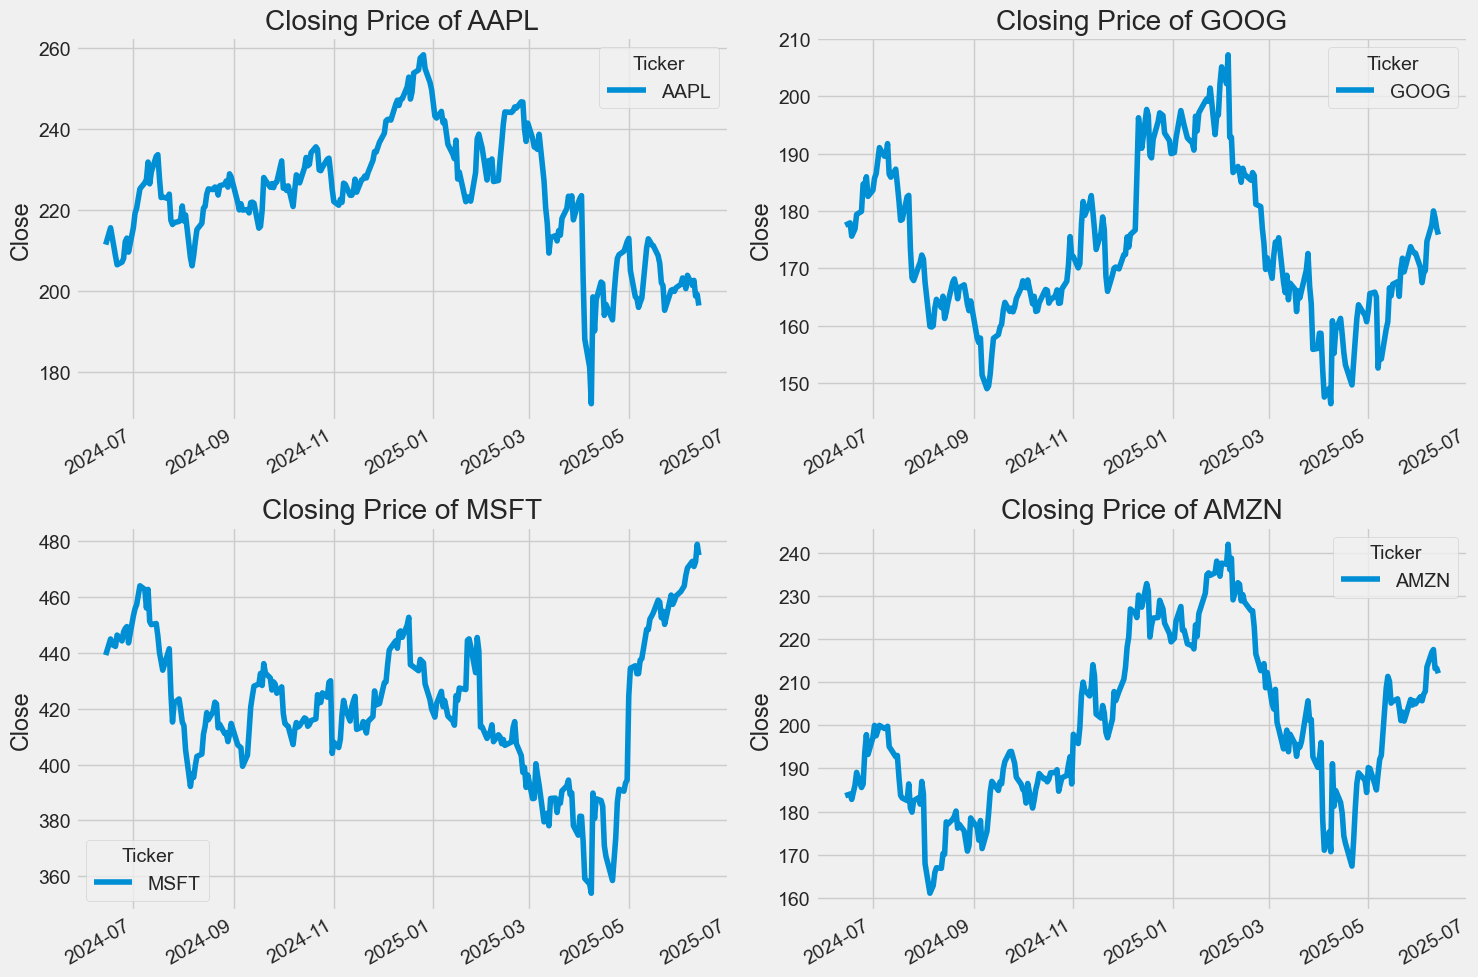

In [62]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(15, 10))  # 2x2 grid

for ax, ticker in zip(axes.flat, tech_list):
    stock_data[ticker]['Close'].plot(ax=ax)
    ax.set_ylabel('Close')
    ax.set_xlabel(None)
    ax.set_title(f"Closing Price of {ticker}")

plt.tight_layout()
plt.show()

AAPL rising to 260 in late 2024 before declining, GOOG peaking at 210 and dropping to 150 by mid-2025, and AMZN reaching 240 before falling to 160, reflecting volatility possibly due to trade tensions and the Q1 2025 GDP contraction. MSFT trends upward to 480 in early 2025 before a slight decline, suggesting resilience amid AI sector strength, with all stocks showing significant fluctuations over the period.

## 1.3 OHLC (Open, High, Low, Close) Plot

OHLC stands for Open, High, Low, Close. It's a way to represent the price movement of a security (like a stock) over a specific period, such as a day or hour. Each OHLC data point provides a snapshot of the trading session, showing the opening price, the highest price reached, the lowest price reached, and the closing price. 

In [63]:
from plotly import graph_objects as go

for stock in tech_list:
    df_stock = stock_data[stock].copy()
    fig = go.Figure(data=[go.Candlestick(
        x=df_stock.index,
        open=df_stock['Open'][stock],
        high=df_stock['High'][stock],
        low=df_stock['Low'][stock],
        close=df_stock['Close'][stock],
        name=stock
    )])

    fig.update_layout(
        title=f'OHLC Price of {stock}',
        xaxis_title='Date',
        yaxis_title='Price (USD)',
        xaxis_rangeslider_visible=True,
        template='plotly_dark',
        height=700,
        width=1200,
    )

    fig.show()

## 1.4 Volume of sales

total number of shares that are bought or sold (traded) within a specific period of time 

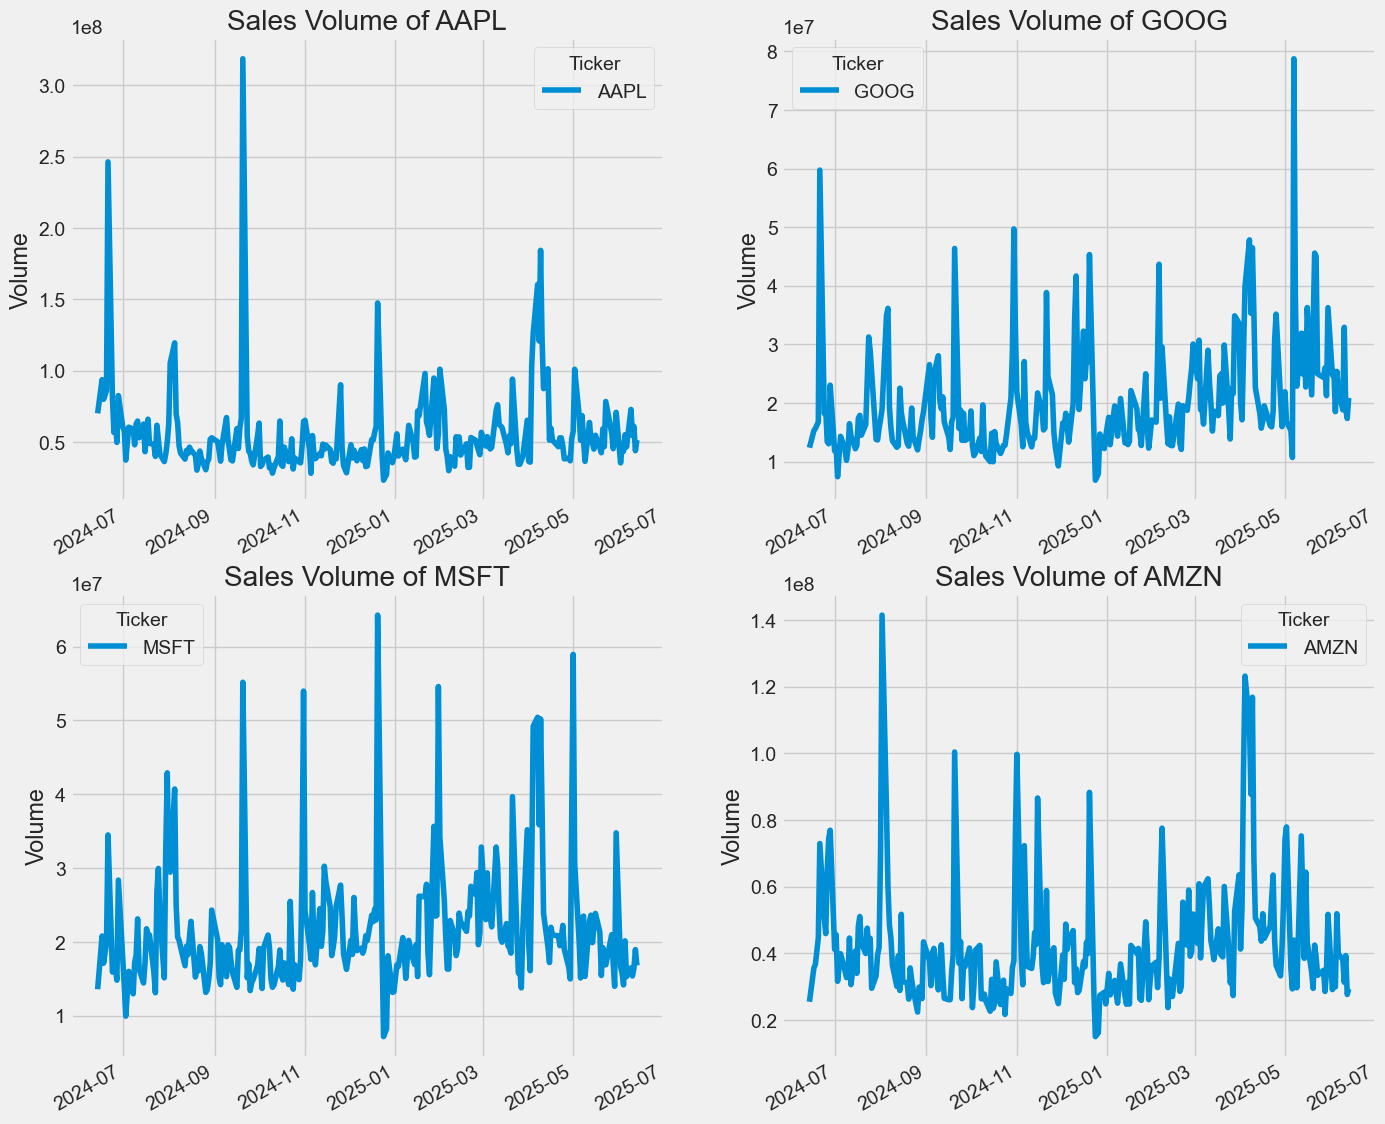

In [12]:
fig, axes = plt.subplots(2, 2, figsize=(15, 15))  # 2x2 grid
for ax, ticker in zip(axes.flat, tech_list):  # Flatten grid
    stock_data[ticker]['Volume'].plot(ax=ax)
    ax.set_ylabel('Volume')
    ax.set_xlabel(None)
    ax.set_title(f"Sales Volume of {ticker}")


AAPL peaking at 3.0 million shares in mid-2024 and stabilizing around 1.5 million by mid-2025, GOOG fluctuating between 1-7 million with a notable spike in early 2025, and MSFT ranging from 2-6 million with peaks in late 2024 and early 2025. AMZN exhibits volumes from 0.4-1.4 million, with significant spikes in late 2024 and mid-2025

## 1.5 Moving Average of Each Stock

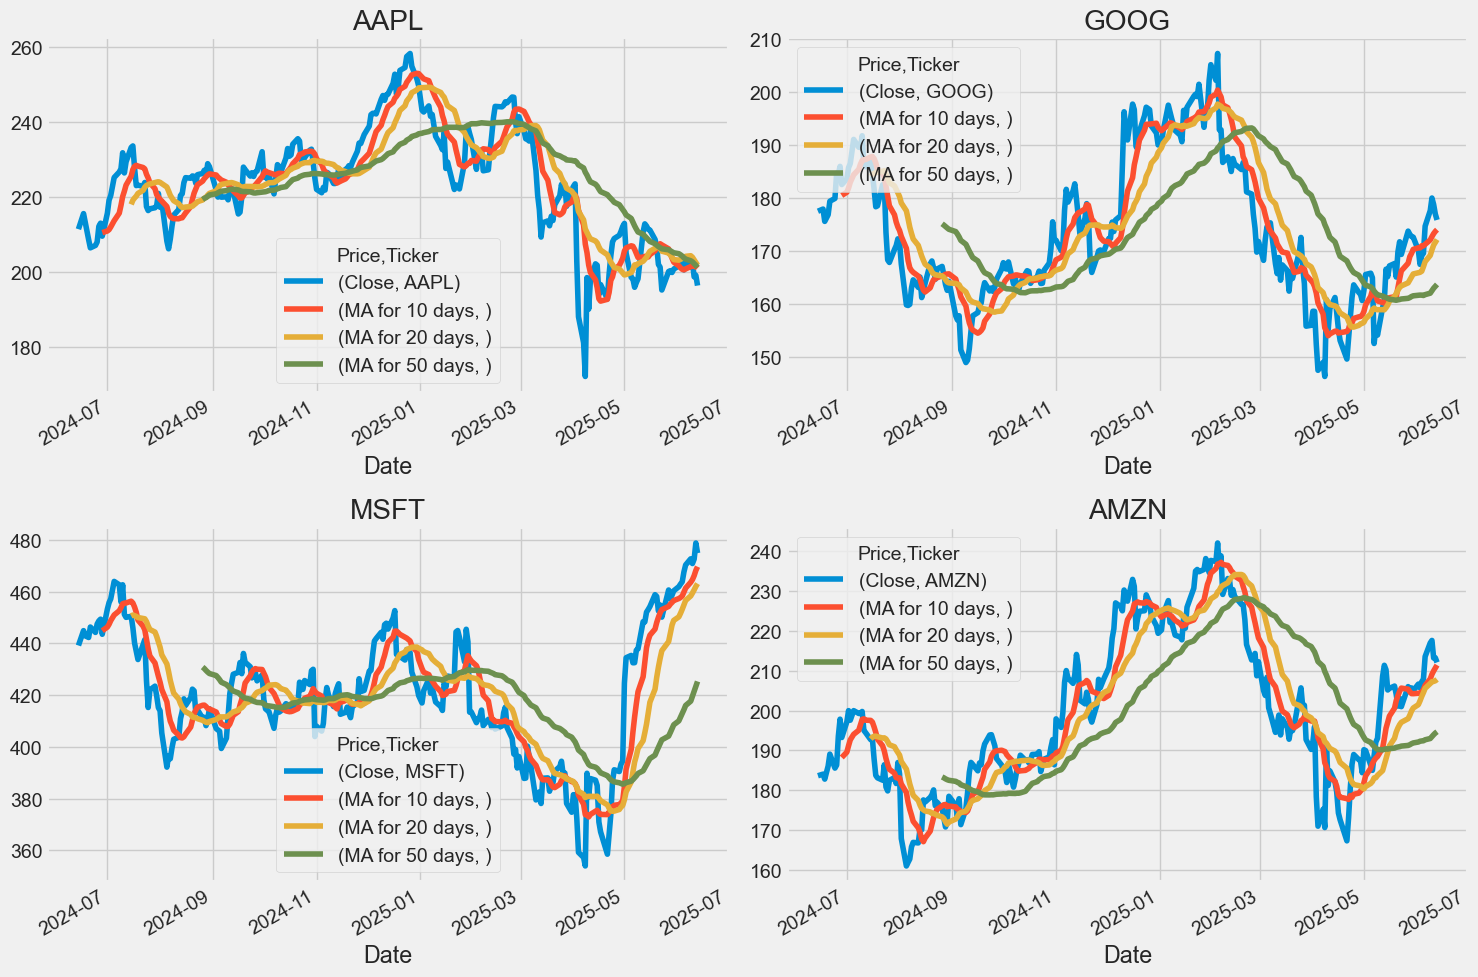

In [64]:
ma_day = [10, 20, 50]

for ma in ma_day:
    for ticker in tech_list:
        column_name = f"MA for {ma} days"
        stock_data[ticker][column_name] = stock_data[ticker]['Close'].rolling(ma).mean()

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))

fig.set_figheight(10)
fig.set_figwidth(15)
for ax, ticker in zip(axes.flat, tech_list):
    stock_data[ticker][['Close', 'MA for 10 days', 'MA for 20 days', 'MA for 50 days']].plot(ax=ax)
    ax.set_title(f"{ticker}")

fig.tight_layout()
plt.show()


AAPL and GOOG decline from early 2025 with converging or diverging MAs suggesting reversals or volatility, possibly due to trade tensions. MSFT peaks in early 2025 with aligned MAs reflecting AI-driven growth, while AMZN follows a similar rise before a mid-2025 drop, with MAs indicating corrections linked to the Q1 2025 GDP contraction.

## 1.6 Daily Returns (Percentage Change)

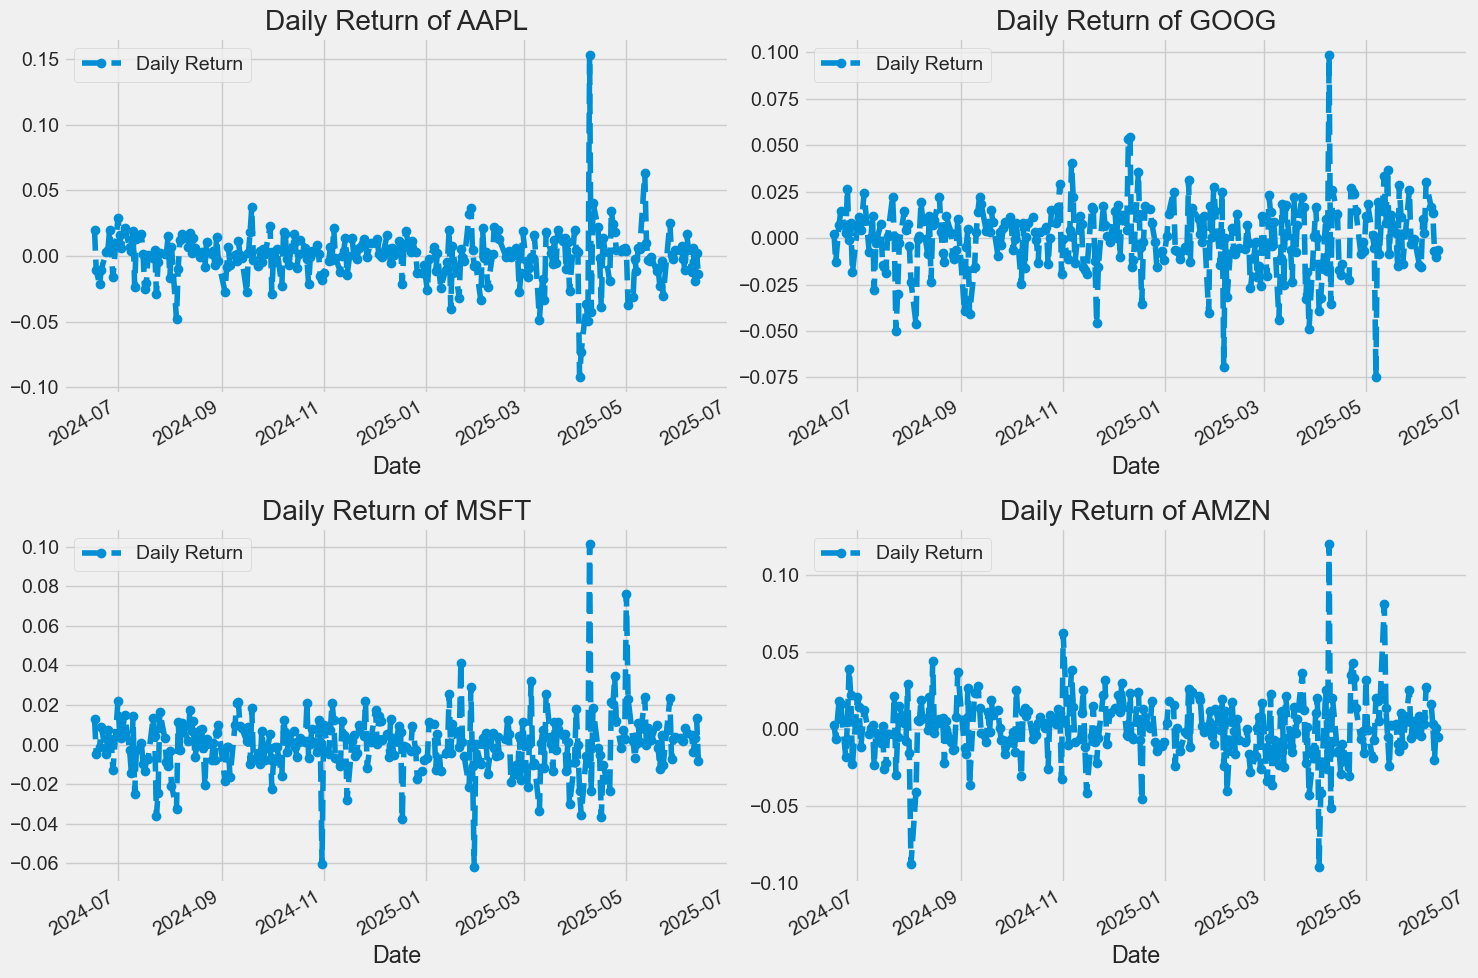

In [65]:
fig, axes = plt.subplots(2, 2)  # 2x2 grid
fig.set_figheight(10)
fig.set_figwidth(15)
for ax, ticker in zip(axes.flat, tech_list):
    stock_data[ticker]['Daily Return'] = stock_data[ticker]['Close'].pct_change()
    stock_data[ticker]['Daily Return'].plot(
        ax=ax, 
        legend=True,
        linestyle='--', 
        marker='o')
    ax.set_title(f"Daily Return of {ticker}")
    
plt.tight_layout()
plt.show()

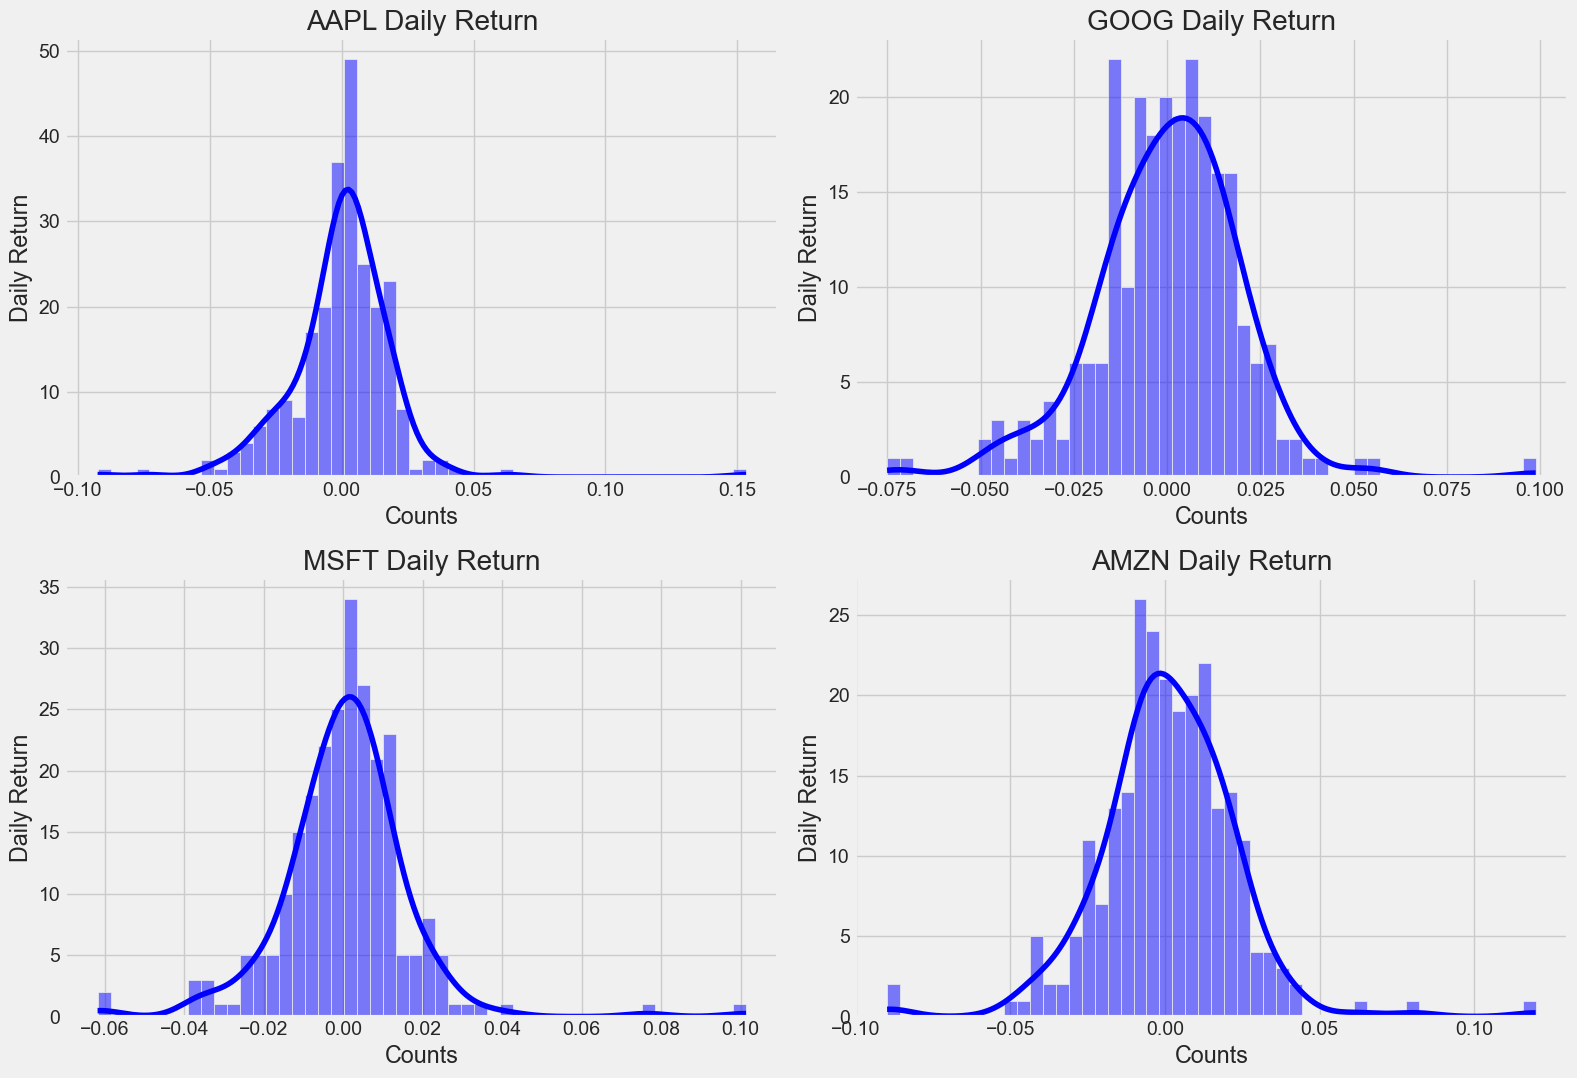

In [66]:
fig, axes = plt.subplots(2,2, figsize=(16,11))
for ax, ticker in zip(axes.flat, tech_list):
    sns.histplot(stock_data[ticker]['Daily Return'].dropna(), bins=50,kde=True, color='blue',ax=ax)
    ax.set_xlabel('Counts')
    ax.set_ylabel('Daily Return')
    ax.set_title(f'{ticker} Daily Return')
    
plt.tight_layout()

AAPL, MSFT, and AMZN exhibit significant positive return spikes (e.g., 0.15 for AAPL, 0.10 for MSFT and AMZN) around late 2024 to mid-2025, likely tied to strong earnings or AI sector gains, while GOOG shows a peak near 0.10, reflecting similar trends. The time series reveals periodic sharp movements, such as drops in early 2025 for GOOG and AMZN, possibly linked to tariff impacts or the Q1 2025 GDP contraction, with overall distributions suggesting higher volatility for MSFT and AMZN.

## 1.7 RSI (Relative Strength Index)

Measures the speed and change of price movements. It helps identify overbought or oversold conditions in a stock.

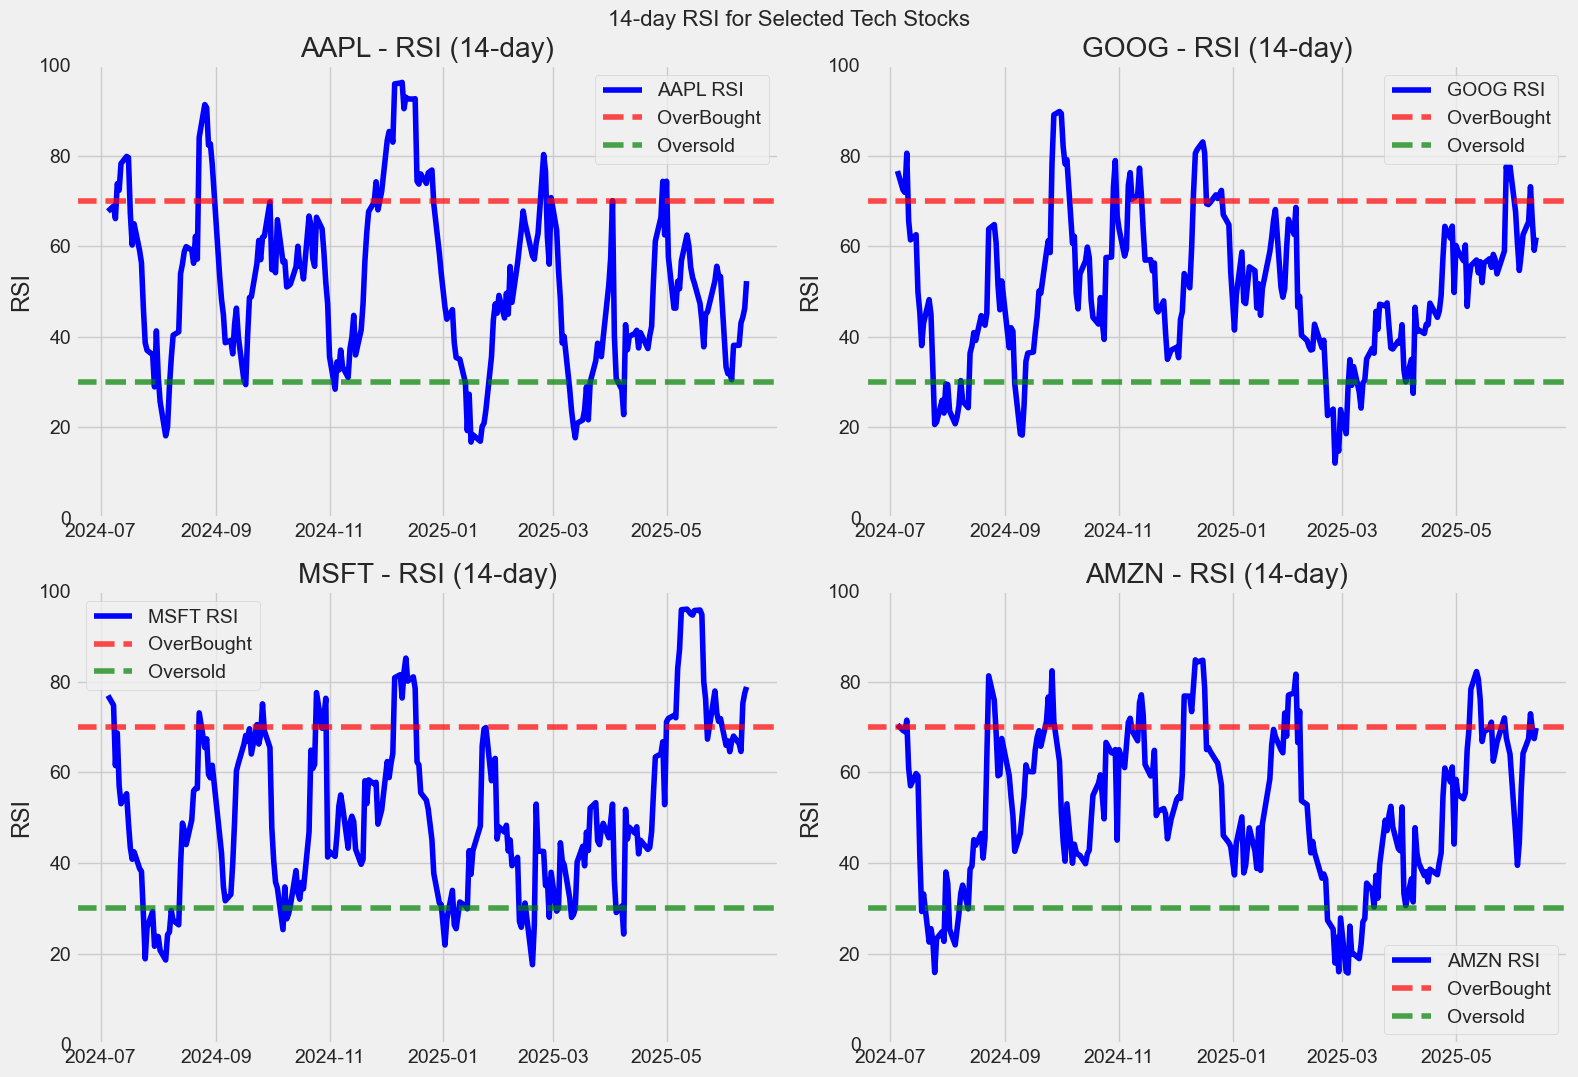

In [8]:
fig, axes = plt.subplots(2, 2, figsize=(16, 11))
fig.suptitle('14-day RSI for Selected Tech Stocks', fontsize=16)

for ax, ticker in zip(axes.flat, tech_list):
    df = stock_data[ticker].copy()
    delta = df['Close'].diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(window=14).mean()
    avg_loss = loss.rolling(window=14).mean()
    rs = avg_gain / avg_loss.replace(0, 1) 
    rsi = 100 - (100 / (1 + rs))
    df['RSI'] = rsi
    ax.plot(df.index, df['RSI'], label=f'{ticker} RSI', color='blue')
    ax.axhline(70, color='red', linestyle='--', alpha=0.7, label='OverBought')
    ax.axhline(30, color='green', linestyle='--', alpha=0.7, label='Oversold')
    ax.set_title(f'{ticker} - RSI (14-day)')
    ax.set_ylim(0, 100)
    ax.set_ylabel('RSI')
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.subplots_adjust(top=0.93)  # Adjust for suptitle
plt.show()


AAPL and GOOG frequently approach or exceed 70 in late 2024 and early 2025, suggesting overbought conditions possibly tied to strong AI-driven gains, while MSFT peaks near 80 in early 2025, reflecting its record high amid market volatility. AMZN shows more balanced movement but dips below 30 in late 2024, hinting at oversold conditions during weaker earnings periods, with all stocks reflecting sensitivity to trade tensions and economic data like the Q1 2025 GDP contraction.

## 1.7 Volatitlity Analysis

Measures how much and how quicly the stock price chagnes overtime. Reflect the market risk and uncertainty

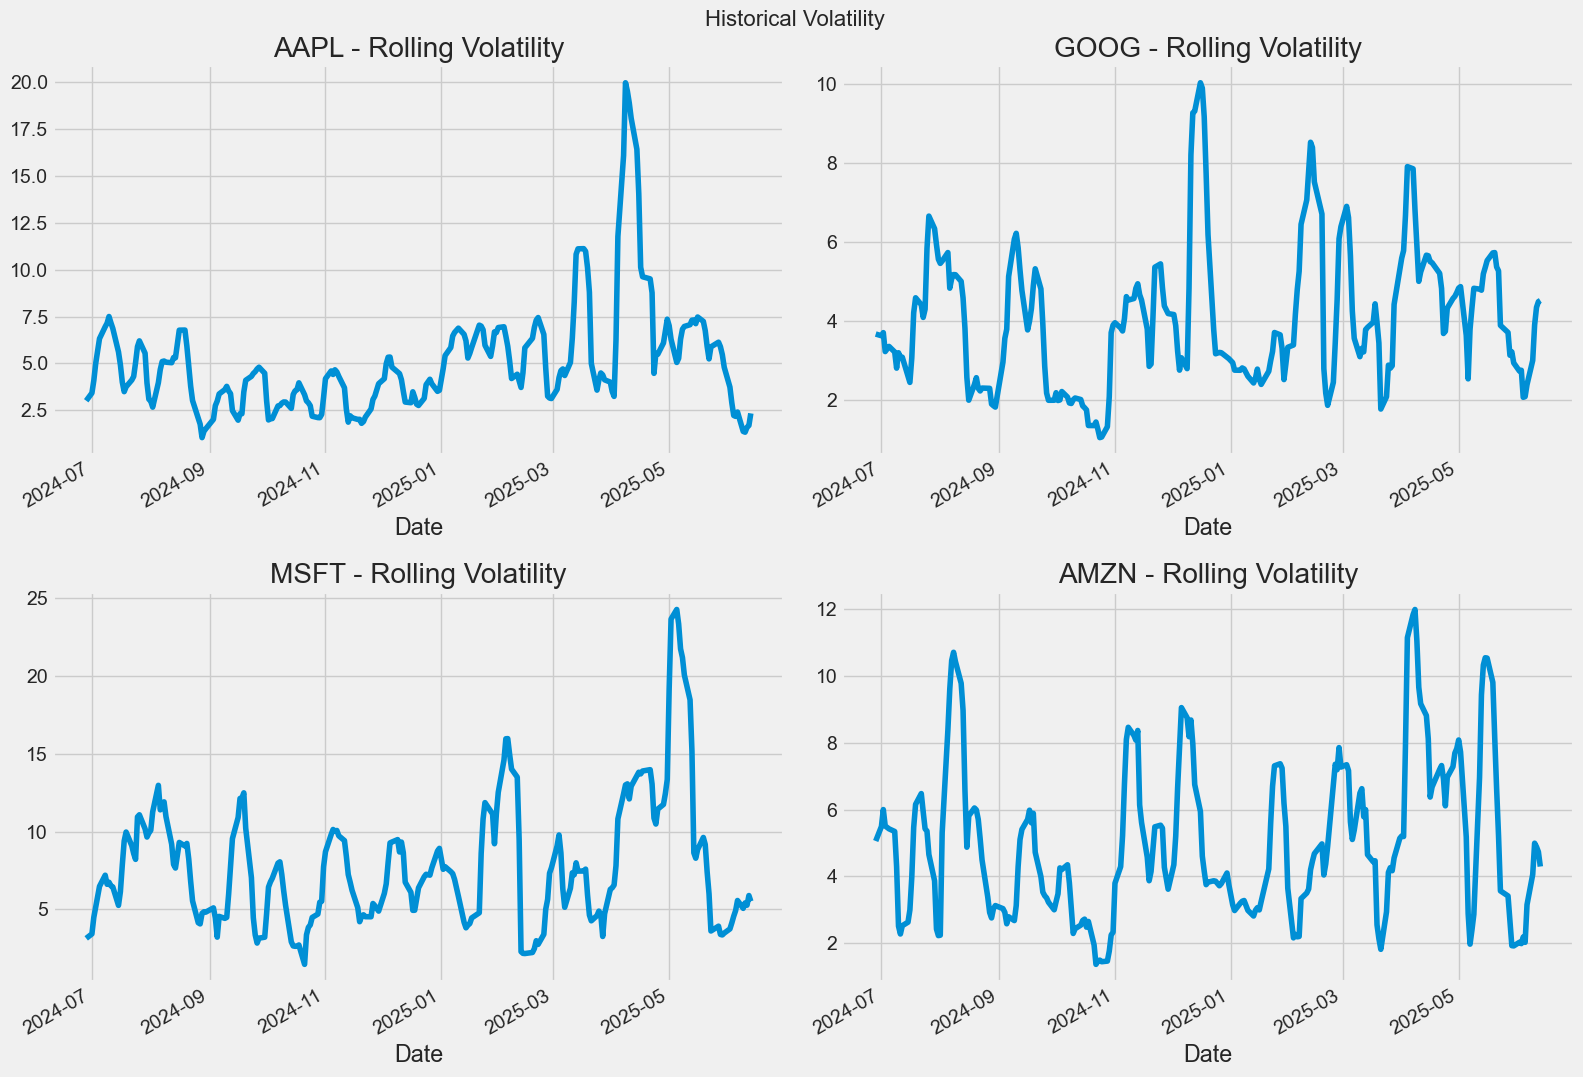

In [10]:
fig, axes = plt.subplots(2, 2, figsize=(16, 11))
fig.suptitle('Historical Volatility', fontsize=16)

for ax, ticker in zip(axes.flat, tech_list):
    df = stock_data[ticker].copy()
    df['volatility'] = df['Close'].rolling(window=10).std()
    df['volatility'].plot(ax=ax)
    ax.set_title(f'{ticker} - Rolling Volatility')
plt.tight_layout()
plt.subplots_adjust(top=0.93)  # Adjust for suptitle
plt.show()

AAPL and MSFT exhibit significant spikes in late 2024 and early 2025, potentially reflecting market reactions to U.S.-China trade tensions and a 0.3% GDP contraction in Q1 2025, while GOOG and AMZN show more frequent but lower-amplitude volatility, possibly due to regulatory pressures and weaker earnings forecasts in mid-2025. The overall trend suggests increasing instability, with MSFT reaching the highest volatility peak around 25, likely tied to its AI sector performance amidst economic uncertainty.

## 1.8 Anomalies Detection

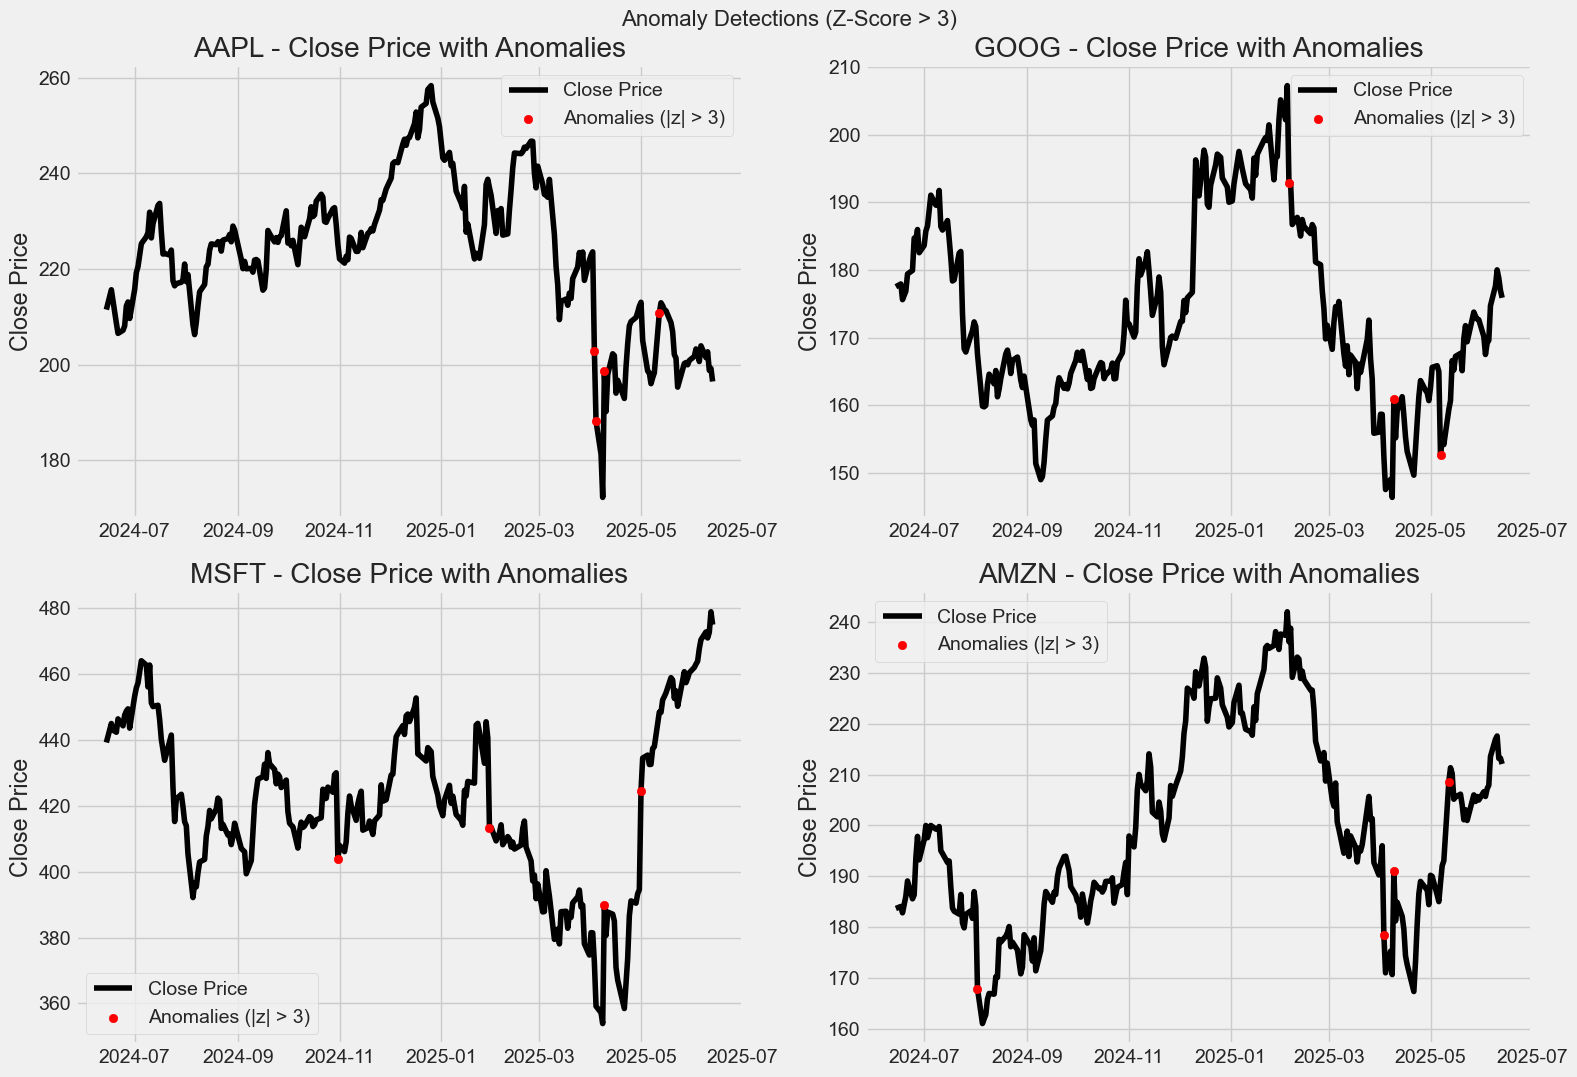

In [11]:
from scipy.stats import zscore
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(16, 11))
fig.suptitle('Anomaly Detections (Z-Score > 3)', fontsize=16)

for ax, ticker in zip(axes.flat, tech_list):
    df = stock_data[ticker].copy()
    df['Daily Return'] = df['Close'].pct_change()
    df['Z-Score'] = zscore(df['Daily Return'].dropna())

    # Align Z-scores with original index (since pct_change and zscore drop first row)
    df['Z-Score'] = df['Z-Score'].reindex(df.index)
    
    # Identify anomalies
    anomalies = df[abs(df['Z-Score']) > 3]

    # Plot close price
    ax.plot(df.index, df['Close'], label='Close Price', color='black')

    # Plot anomalies
    ax.scatter(anomalies.index, anomalies['Close'], 
               color='red', label='Anomalies (|z| > 3)', zorder=5)

    ax.set_title(f'{ticker} - Close Price with Anomalies')
    ax.set_ylabel('Close Price')
    ax.grid(True)
    ax.legend()

plt.tight_layout()
plt.subplots_adjust(top=0.93)
plt.show()


AAPL: Anomalies appear around late 2024 and mid-2025, with price drops or spikes from a general upward trend.
GOOG: Anomalies occur in late 2024 and early 2025, coinciding with significant price declines or volatility.
MSFT: Anomalies are noted in late 2024 and mid-2025, often during price corrections or sharp movements.
AMZN: Anomalies are clustered in late 2024 and mid-2025, aligning with notable price drops or fluctuations.

# 2. Correlation between different stock closing prices

## 2.1 Correlation Analysis

Correlation is a statistic that measures the degree to which two variables move in relation to each other which has a value that must fall between -1.0 and +1.0. Correlation measures association, but doesn’t show if x causes y or vice versa — or if the association is caused by a third factor.

In [13]:
closing_df = yf.download(tech_list, start=start, end=end)['Close']
tech_rets = closing_df.pct_change()
tech_rets.head()

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  4 of 4 completed


Ticker          AAPL      AMZN      GOOG      MSFT
Date                                              
2024-06-14       NaN       NaN       NaN       NaN
2024-06-17  0.019672  0.002178  0.002299  0.013105
2024-06-18 -0.010985 -0.006791 -0.013033 -0.004528
2024-06-20 -0.021513  0.017997  0.007141 -0.001434
2024-06-21 -0.010444  0.016013  0.014349  0.009154

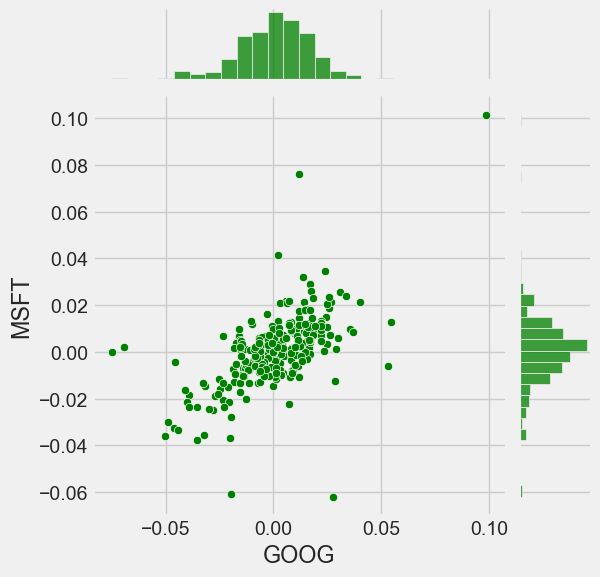

In [14]:
#compare daily returns from of google microsoft
sns.jointplot(x='GOOG', y='MSFT', data=tech_rets, kind='scatter', color='green')

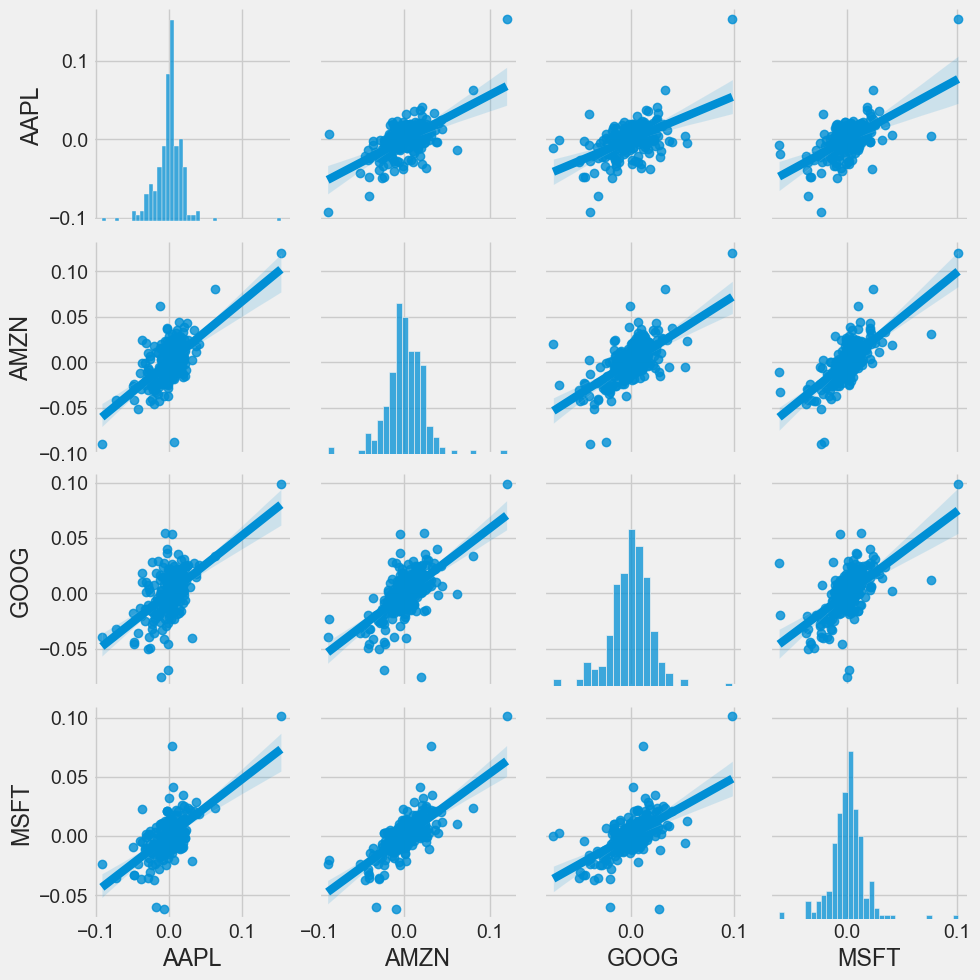

In [15]:
sns.pairplot(data=tech_rets, kind='reg')

The scatter plots are tightly clustered around the regression line, meaning the returns of these stocks are positively correlated.
This suggests that when one stock increases, the others tend to increase as well.


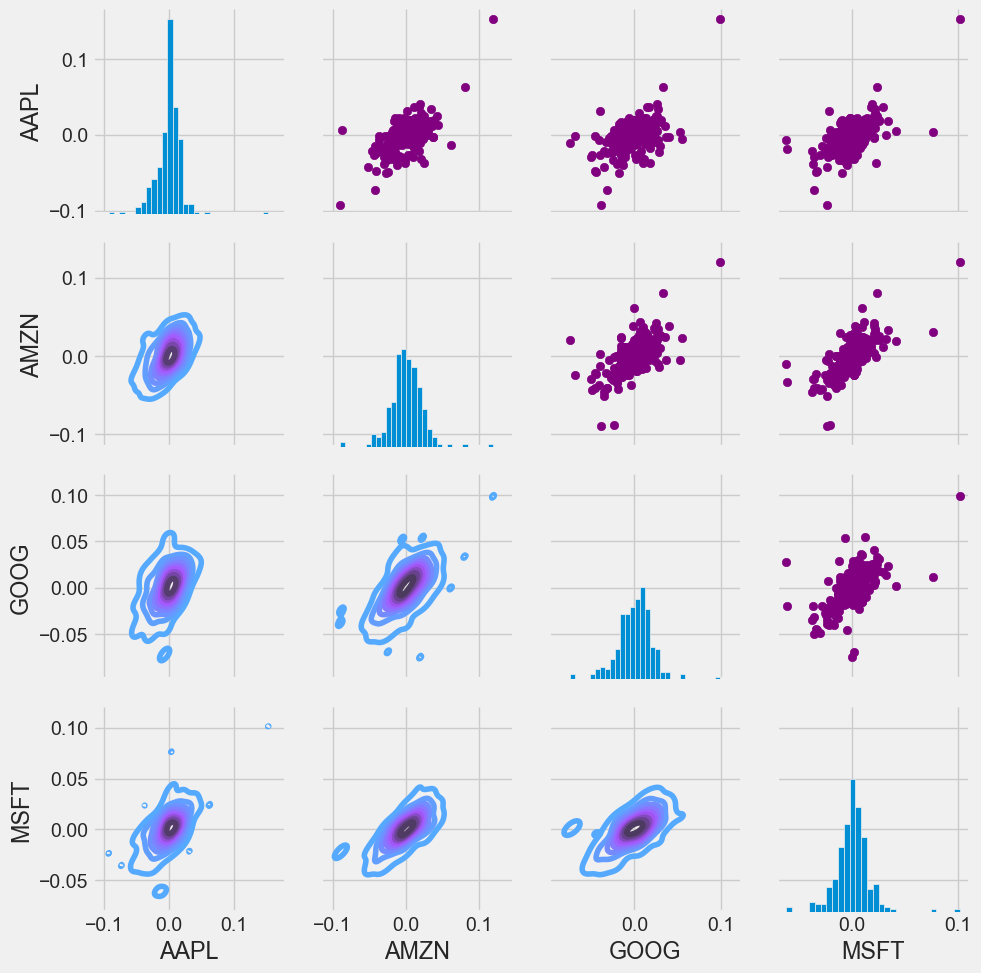

In [16]:
tech_rets_cleaned = tech_rets.replace([np.inf, -np.inf], np.nan).dropna()
return_fig = sns.PairGrid(tech_rets_cleaned)
return_fig.map_upper(plt.scatter, color="Purple")
return_fig.map_lower(sns.kdeplot, cmap="cool_d")
return_fig.map_diag(plt.hist, bins=30)


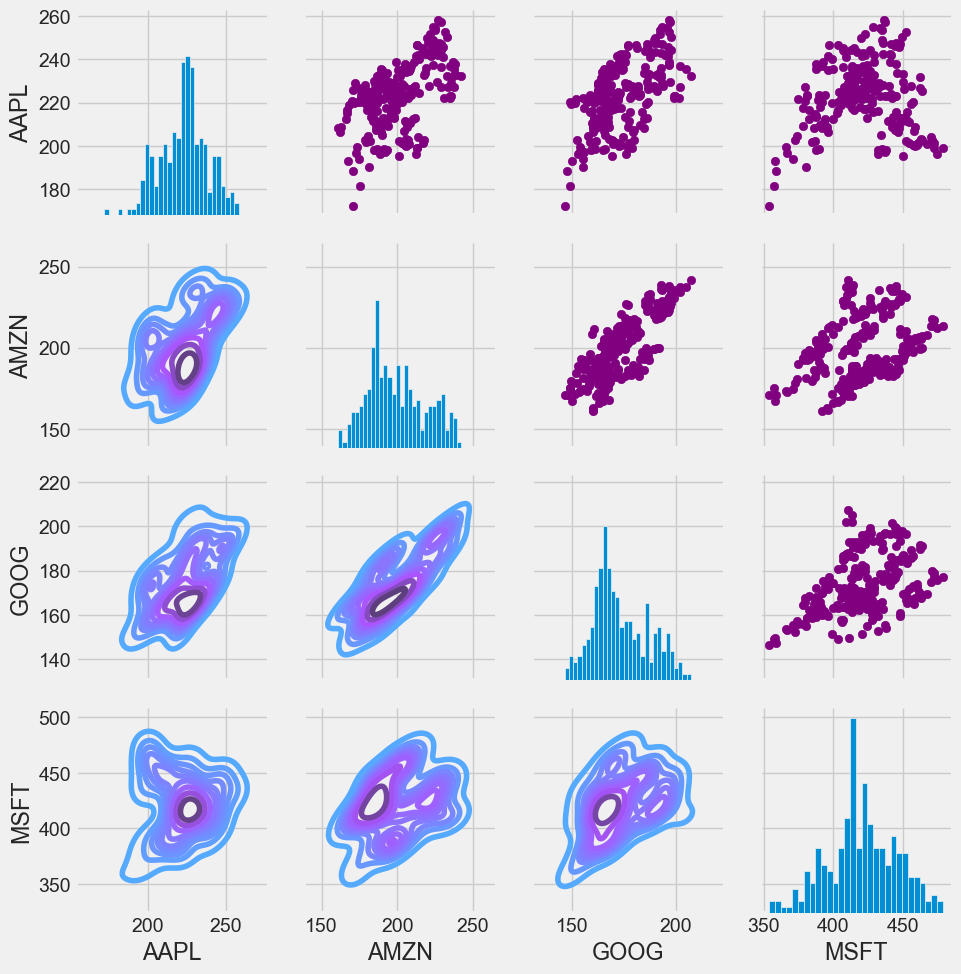

In [17]:
returns_fig = sns.PairGrid(closing_df)
returns_fig.map_upper(plt.scatter,color='purple')
returns_fig.map_lower(sns.kdeplot,cmap='cool_d')
returns_fig.map_diag(plt.hist,bins=30)

Text(0.5, 1.0, 'Correlation of stock closing price')

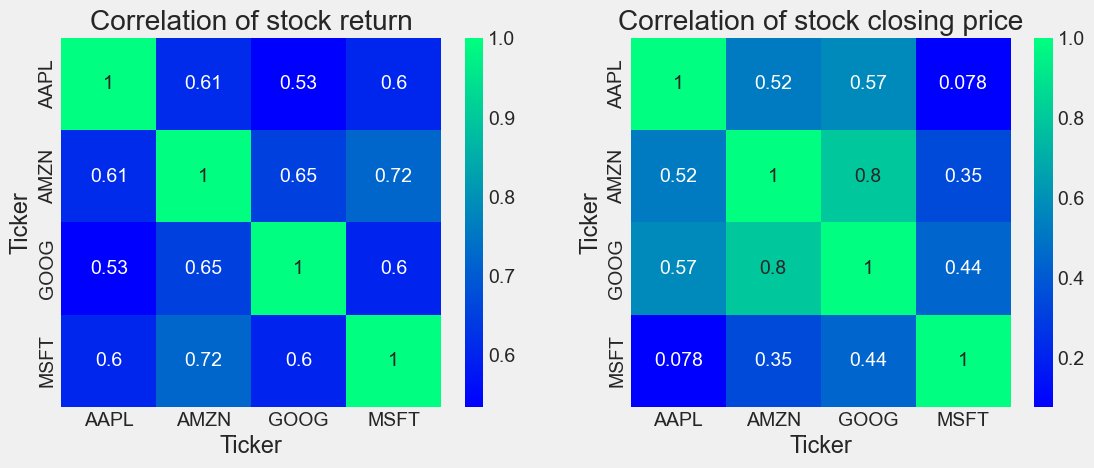

In [18]:
plt.figure(figsize=(12,10))

plt.subplot(2,2,1)
sns.heatmap(tech_rets.corr(), annot=True, cmap='winter')
plt.title('Correlation of stock return')

plt.subplot(2, 2, 2)
sns.heatmap(closing_df.corr(), annot=True, cmap='winter')
plt.title('Correlation of stock closing price')


The correlation plots for AAPL, AMZN, GOOG, and MSFT from July 2024 to June 2025 reveal strong positive correlations in stock returns (0.53-0.72), with the highest between AMZN and GOOG (0.65) and the lowest between AAPL and GOOG (0.53), reflecting synchronized tech sector movements. Closing price correlations are slightly lower (0.35-0.78), with the strongest between AAPL and MSFT (0.78) and the weakest between AMZN and MSFT (0.35)

## 2.2 Comparing Each Stock Risk and Return

Comparing the expected return with the standard deviation of the daily returns

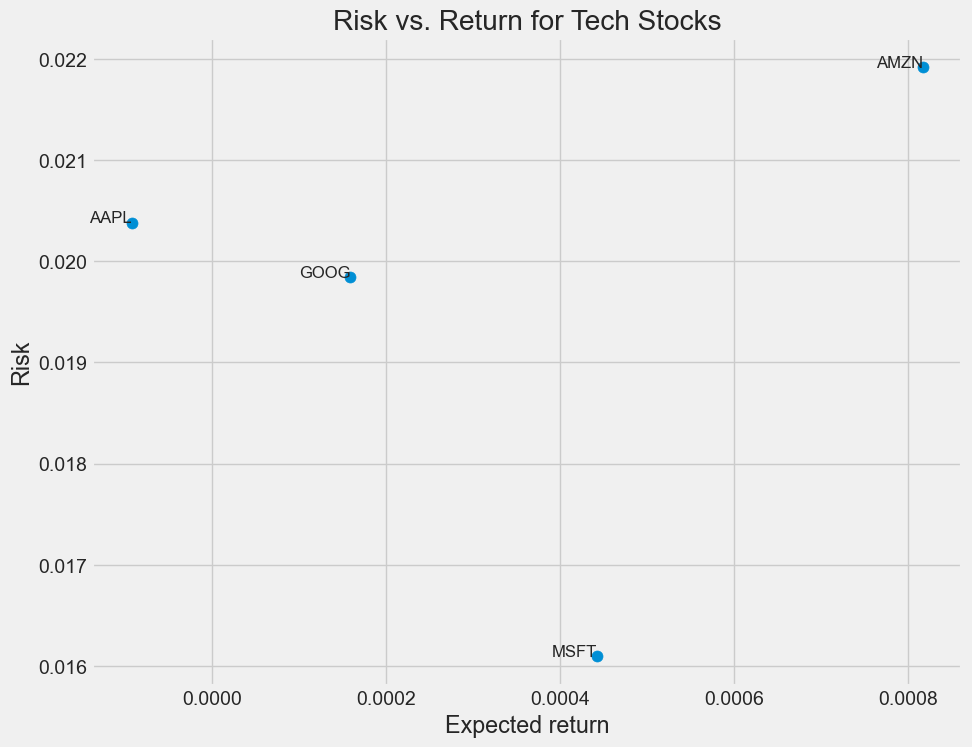

In [19]:
rets = tech_rets.dropna()

area = np.pi * 20

plt.figure(figsize=(10, 8))
plt.scatter(rets.mean(), rets.std(), s=area)
plt.xlabel('Expected return')
plt.ylabel('Risk')

for i, name in enumerate(rets.columns):
    plt.text(rets.mean()[i], rets.std()[i], name, fontsize=12, ha='right')

plt.title('Risk vs. Return for Tech Stocks')
plt.grid(True)
plt.show()

Amazon (AMZN) offers the highest expected return but also comes with the highest risk, while Microsoft (MSFT) provides the lowest return with the least risk, making it the most conservative option. Apple (AAPL) and Google (GOOG) lie in between, with AAPL offering a balanced profile and GOOG leaning slightly more toward higher risk and return.

# 3. Forecasting

In [2]:
df = yf.download('AAPL', start='2020-01-01', end=datetime.now())

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


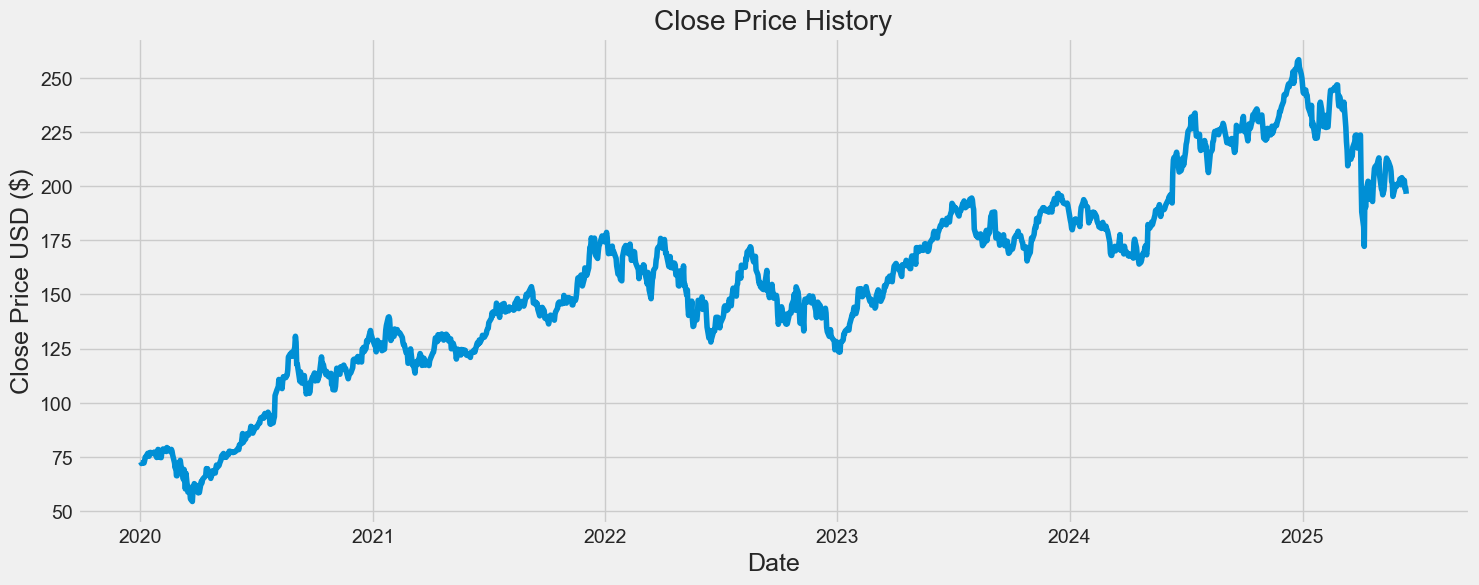

In [3]:
plt.figure(figsize=(16,6))
plt.title('Close Price History')
plt.plot(df['Close'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.show()


## 3.1 Traditional Statistical Model (ARIMA)

### 3.1.1 Adfuller Stationarity Checks function

In [4]:
def ad_fuller_func(X):
    result_ad_fuller = adfuller(X)
    print('ADF Statistic: %f' % result_ad_fuller[0])
    print('p-value: %f' %result_ad_fuller[1])
    print('Critical Values:')
    for key, value in result_ad_fuller[4].items():
        print('\t%s: %.3f' % (key, value))
    if result_ad_fuller[0] < result_ad_fuller[4]['5%']:
        print('Reject Null Hypothesis (Time series data is Stationary)')
    else:
        print('Failed to Reject Null Hypothesis (Non Stationary)')

ad_fuller_func(df[['Close']])

ADF Statistic: -1.821249
p-value: 0.369964
Critical Values:
	1%: -3.435
	5%: -2.864
	10%: -2.568
Failed to Reject Null Hypothesis (Non Stationary)


### 3.1.2 Apply Differencing

In [5]:
df_diff = df['Close'] - df['Close'].shift(2)
df_diff.dropna(inplace=True)

In [6]:
ad_fuller_func(df_diff)

ADF Statistic: -7.262752
p-value: 0.000000
Critical Values:
	1%: -3.435
	5%: -2.864
	10%: -2.568
Reject Null Hypothesis (Time series data is Stationary)


### 3.1.3 AutoCorrelation Function (AFC)

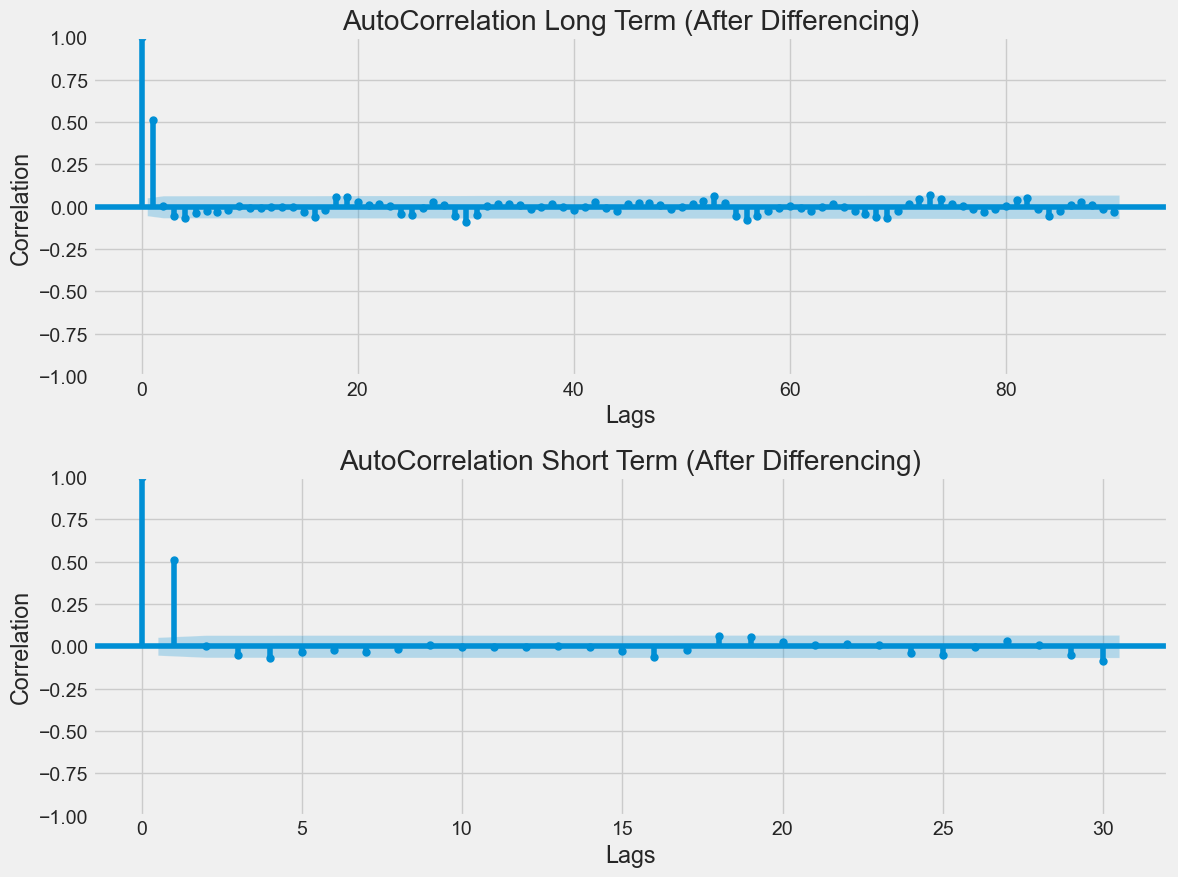

In [7]:
from statsmodels.graphics.tsaplots import plot_acf

fig,(ax1,ax2) = plt.subplots(2,figsize=(12,9))
acf = plot_acf(df_diff,lags=90,ax=ax1)
ax1.set_title('AutoCorrelation Long Term (After Differencing)')
acf = plot_acf(df_diff,lags=30,ax=ax2)
ax2.set_title('AutoCorrelation Short Term (After Differencing)')
ax1.set_ylabel('Correlation')
ax1.set_xlabel('Lags')
ax2.set_ylabel('Correlation')
ax2.set_xlabel('Lags')
plt.tight_layout()
plt.show()

### 3.1.4 Partial Auto Correlation Function (PACF)

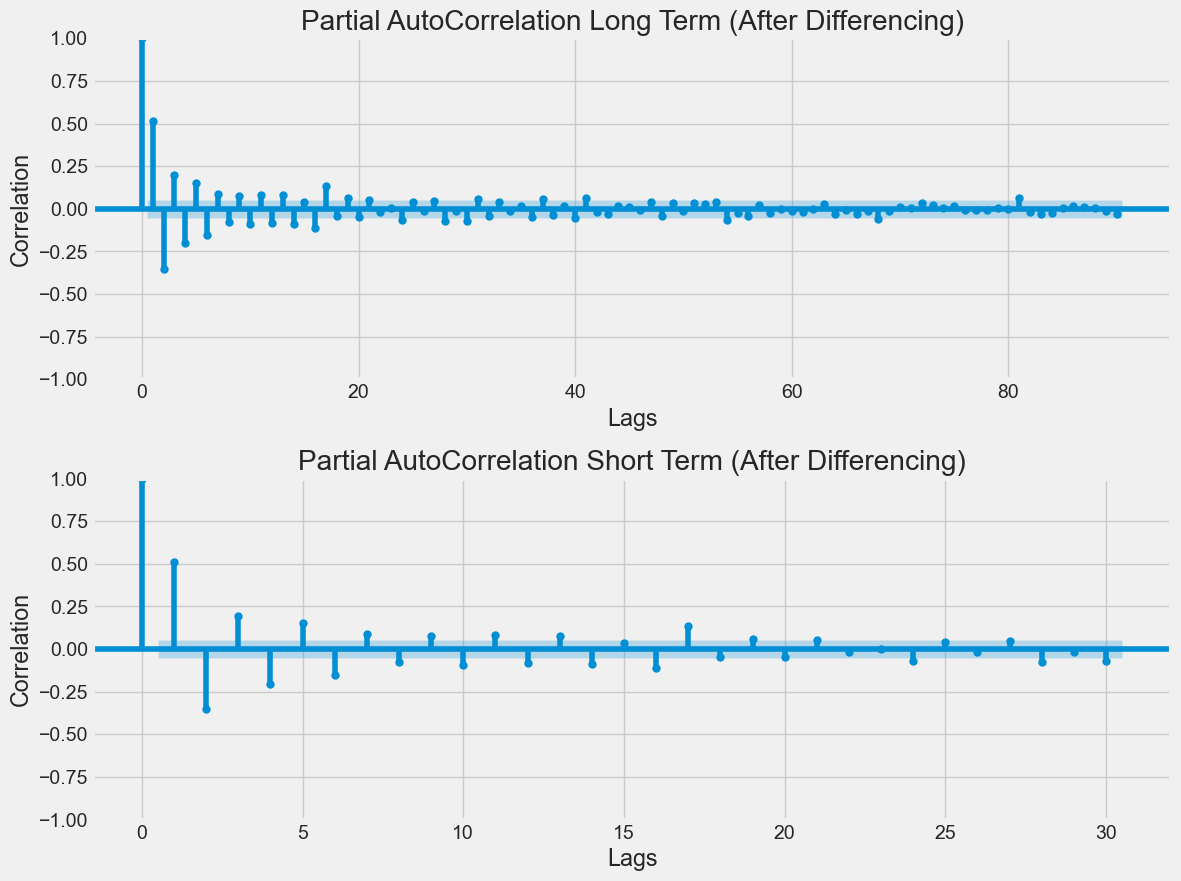

In [8]:
from statsmodels.graphics.tsaplots import plot_pacf

fig,(ax1,ax2) = plt.subplots(2,figsize=(12,9))
pacf = plot_pacf(df_diff,lags=90,ax=ax1)
ax1.set_title('Partial AutoCorrelation Long Term (After Differencing)')
pacf = plot_pacf(df_diff,lags=30,ax=ax2)
ax2.set_title('Partial AutoCorrelation Short Term (After Differencing)')
ax1.set_ylabel('Correlation')
ax1.set_xlabel('Lags')
ax2.set_ylabel('Correlation')
ax2.set_xlabel('Lags')
plt.tight_layout(pad=1)

### 3.1.5 STL Decomposition

In [9]:
from statsmodels.tsa.seasonal import STL
n = len(df)
train_size = int(n * 0.7)
test_size = int(n * 0.15)
val_size = n - train_size - test_size
df['Close_log'] = np.log(df['Close'])
train = df[['Close_log']].iloc[:train_size]
test = df[['Close_log']].iloc[train_size:train_size + test_size]
val = df[['Close_log']].iloc[train_size + test_size:]
print(f"Train size: {len(train)}, Test size: {len(test)}, Val size: {len(val)}")

seasonal_periods = [5, 21, 63, 252]  # Weekly, monthly, quarterly (trading days)
for period in seasonal_periods:
    stl = STL(train['Close_log'], period=period, robust=True)
    result = stl.fit()
    seasonal_strength = max(0, 1 - np.var(result.resid) / np.var(result.resid + result.seasonal))
    print(f"Seasonal Strength (period={period}): {seasonal_strength:.3f}")


Train size: 958, Test size: 205, Val size: 207
Seasonal Strength (period=5): 0.039
Seasonal Strength (period=21): 0.047
Seasonal Strength (period=63): 0.111
Seasonal Strength (period=252): 0.167


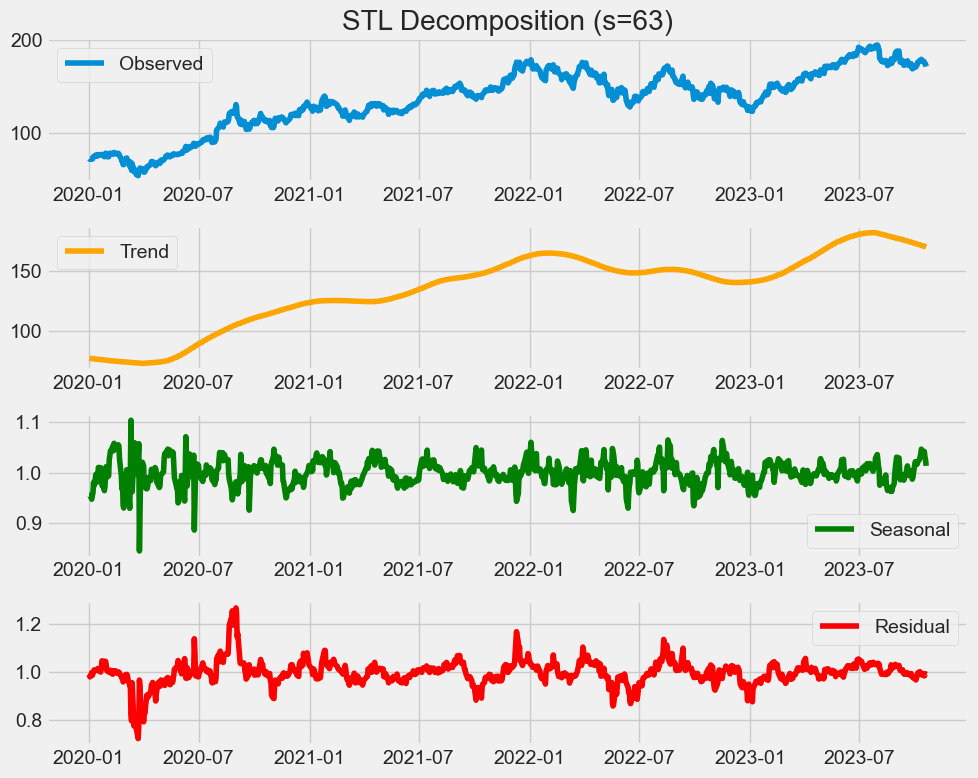

In [10]:
stl = STL(train['Close_log'], period=63, robust=True)

result = stl.fit()
trend = np.exp(result.trend)
seasonal = np.exp(result.seasonal)  # Approximate for visualization
residual = np.exp(result.resid)  # Approximate
plt.figure(figsize=(10, 8))
plt.subplot(4, 1, 1)
plt.plot(train.index, np.exp(train['Close_log']), label='Observed')
plt.title('STL Decomposition (s=63)')
plt.legend()
plt.subplot(4, 1, 2)
plt.plot(train.index, trend, label='Trend', color='orange')
plt.legend()
plt.subplot(4, 1, 3)
plt.plot(train.index, seasonal, label='Seasonal', color='green')
plt.legend()
plt.subplot(4, 1, 4)
plt.plot(train.index, residual, label='Residual', color='red')
plt.legend()
plt.tight_layout()
plt.show()

### 3.1.6 Fitting ARIMA

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


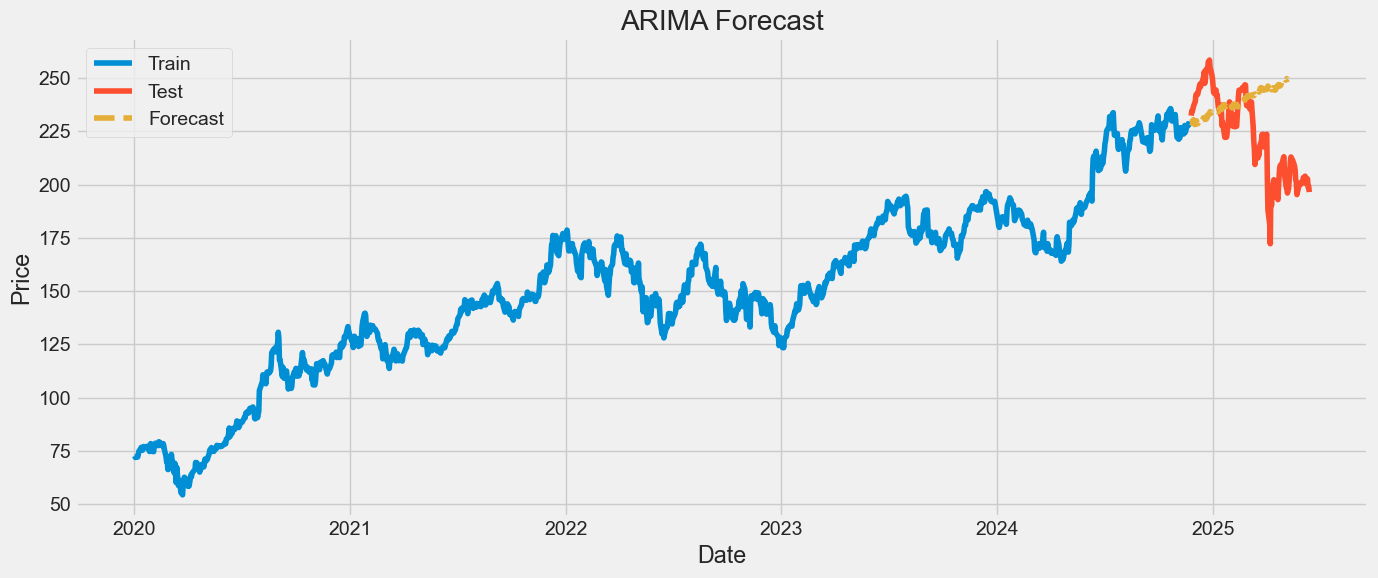

In [11]:
df = df[['Close']].dropna()
df.index = pd.to_datetime(df.index)

n = len(df)

train_size = int(n * 0.9)
train = df.iloc[:train_size]
test = df.iloc[train_size:]

model = ARIMA(train['Close'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 63))
results = model.fit()

forecast_steps = len(test) + 30
forecast_index = pd.date_range(start=train.index[-1] + pd.Timedelta(days=1), periods=forecast_steps, freq='D')
forecast = results.forecast(steps=forecast_steps)
forecast_series = pd.Series(forecast.values, index=forecast_index)

plt.figure(figsize=(14, 6))
plt.plot(train.index, train['Close'], label='Train')
plt.plot(test.index, test['Close'], label='Test')
plt.plot(forecast_index, forecast_series, label='Forecast', linestyle='--')
plt.title('ARIMA Forecast')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.tight_layout()
plt.show()


In [12]:
test_forecast = forecast_series[:len(test)]
arima_rmse = np.sqrt(np.mean(((test_forecast - test['Close']['AAPL']) ** 2)))
print(f"ARIMA Root Mean Squared Errors(RMSE): {arima_rmse}")

ARIMA Root Mean Squared Errors(RMSE): 19.787310437977332


## 3.2 Deep Learning

In [13]:
data = df['Close']
dataset = data.values
training_data_len = int(np.ceil(len(dataset) * .95))
training_data_len

1302

In [14]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)
scaled_data

array([[0.0894149 ],
       [0.08595434],
       [0.08876305],
       ...,
       [0.70778734],
       [0.70984597],
       [0.69636677]])

In [15]:
# using 60 days sliding window
train_data = scaled_data[:training_data_len, :]
test_data = scaled_data[training_data_len - 60: , :]
x_train = []
y_train = []
x_test = []
y_test = dataset[training_data_len:, :]

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])

for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])

x_train, y_train, x_test= np.array(x_train), np.array(y_train), np.array(x_test)

x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))


### 3.2.1 LSTM

In [16]:
def lstm_model():
    model = Sequential()
    model.add(LSTM(128, return_sequences=True, input_shape= (x_train.shape[1], 1)))
    model.add(LSTM(64, return_sequences=True))
    model.add(LSTM(32, return_sequences=False))
    model.add(Dense(25))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

lstm_model = lstm_model()
lstm_history = lstm_model.fit(x_train, y_train,epochs=50)

Epoch 1/50


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


39/39 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - loss: 0.0689
Epoch 2/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0018
Epoch 3/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0012
Epoch 4/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - loss: 0.0013
Epoch 5/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - loss: 0.0011
Epoch 6/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - loss: 0.0011
Epoch 7/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - loss: 0.0012
Epoch 8/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - loss: 0.0011
Epoch 9/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - loss: 0.0011
Epoch 10/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - loss: 0.0010
Epoch 11/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - loss: 8.8478e-04
Epoch 12/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - loss: 9.4017e-04
Epoch 13/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - loss: 8.9129e-04
Epoch 14/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - loss: 8.2770e-04
Epoch 15/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - loss: 8.4342

In [17]:
lstm_predictions = lstm_model.predict(x_test)
lstm_predictions = scaler.inverse_transform(lstm_predictions)

lstm_rmse = np.sqrt(np.mean(((lstm_predictions - y_test) ** 2)))
print(f"LSTM Root Mean Squared Error: {lstm_rmse}")


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
LSTM Root Mean Squared Error: 7.3277439804012126


### 3.2.2 CNN + LSTM

In [18]:
def cnn_lstm():
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(60,1))),
    model.add(AveragePooling1D(pool_size=1)),
    model.add(LSTM(128, return_sequences=True))
    model.add(LSTM(32, return_sequences=False))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model
cnn_lstm_model = cnn_lstm()

cnn_lstm_history = cnn_lstm_model.fit(x_train, y_train,epochs=50)

Epoch 1/50


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 0.0654
Epoch 2/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0015
Epoch 3/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - loss: 8.9987e-04
Epoch 4/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - loss: 8.2494e-04
Epoch 5/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - loss: 8.9879e-04
Epoch 6/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 7.4835e-04
Epoch 7/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - loss: 7.7481e-04
Epoch 8/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - loss: 7.3770e-04
Epoch 9/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 7.3297e-04
Epoch 10/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - loss: 6.8077e-04
Epoch 11/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 6.8709e-04
Epoch 12/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - loss: 6.1726e-04
Epoch 13/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - loss: 6.0392e-04
Epoch 14/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - loss: 7.2120e-04
Epoch 15/50
39/39 ━━━━━━━━━━━━━━━━

In [19]:
cnn_lstm_predictions = cnn_lstm_model.predict(x_test)
cnn_lstm_predictions = scaler.inverse_transform(cnn_lstm_predictions)

# Get the root mean squared error (RMSE)
cnn_lstm_rmse = np.sqrt(np.mean(((cnn_lstm_predictions - y_test) ** 2)))
print(f"CNN + LSTM Root Mean Squared Error: {cnn_lstm_rmse}")


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
CNN + LSTM Root Mean Squared Error: 5.911660317631569


In [20]:
# forecast for 30 days
n_days = 30


last_60_days = scaled_data[-60:] 
lstm_forecast_input = last_60_days.reshape(1, 60, 1) 
cnn_lstm_forecast_input = last_60_days.reshape(1, 60, 1)


lstm_forecasted = []
cnn_lstm_forecasted  = []

for _ in range(n_days):

    lstm_next_pred = lstm_model.predict(lstm_forecast_input)[0, 0] 
    cnn_lstm_next_pred = cnn_lstm_model.predict(cnn_lstm_forecast_input)[0, 0] 

    lstm_forecasted.append(lstm_next_pred) 
    cnn_lstm_forecasted.append(cnn_lstm_next_pred)
    
    lstm_new_input = np.append(lstm_forecast_input.flatten()[1:], lstm_next_pred) 
    cnn_lstm_new_input = np.append(cnn_lstm_forecast_input.flatten()[1:], cnn_lstm_next_pred) 
    lstm_forecast_input = lstm_new_input.reshape(1, 60, 1)
    cnn_lstm_forecast_input = cnn_lstm_new_input.reshape(1, 60, 1)


lstm_forecasted_prices = scaler.inverse_transform(np.array(lstm_forecasted).reshape(-1, 1))
cnn_lstm_forecasted_prices = scaler.inverse_transform(np.array(cnn_lstm_forecasted).reshape(-1, 1))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━

In [21]:
print("LSTM Forecasted prices for the next", n_days, "days:")
print(lstm_forecasted_prices.flatten())

LSTM Forecasted prices for the next 30 days:
[195.26907 193.69815 192.24594 190.88922 189.60526 188.37694 187.18956
 186.03075 184.89108 183.76514 182.65128 181.55081 180.4667  179.40274
 178.36281 177.35004 176.36711 175.41537 174.4953  173.60661 172.74829
 171.91875 171.11617 170.33853 169.5839  168.85039 168.13635 167.44019
 166.76056 166.09628]


In [22]:
print("CNN + LSTM Forecasted prices for the next", n_days, "days:")
print(cnn_lstm_forecasted_prices.flatten())

CNN + LSTM Forecasted prices for the next 30 days:
[196.73079 196.78818 197.07799 197.34883 197.61163 197.8412  198.03902
 198.20816 198.35478 198.48473 198.60283 198.71254 198.81612 198.91478
 199.00902 199.099   199.18462 199.26581 199.3425  199.41469 199.48247
 199.54608 199.60568 199.66167 199.71445 199.7644  199.81204 199.85773
 199.90186 199.94478]


In [23]:
lstm_predictions = np.concatenate([lstm_predictions, lstm_forecasted_prices])
cnn_lstm_predictions = np.concatenate([cnn_lstm_predictions, cnn_lstm_forecasted_prices])

In [24]:
train = data[:training_data_len]
test = data[training_data_len:]

pred_dates = [df.index[training_data_len] + timedelta(days=i) for i in range(len(lstm_predictions))]
forecast_df =  pd.DataFrame({
    'LSTM_Forecast': lstm_predictions.flatten(),
    'CNN_LSTM_Forecast': cnn_lstm_predictions.flatten()}, index=pred_dates)


In [25]:
print(len(test), len(forecast_df))

68 98


In [26]:
data.index

DatetimeIndex(['2020-01-02', '2020-01-03', '2020-01-06', '2020-01-07',
               '2020-01-08', '2020-01-09', '2020-01-10', '2020-01-13',
               '2020-01-14', '2020-01-15',
               ...
               '2025-06-02', '2025-06-03', '2025-06-04', '2025-06-05',
               '2025-06-06', '2025-06-09', '2025-06-10', '2025-06-11',
               '2025-06-12', '2025-06-13'],
              dtype='datetime64[ns]', name='Date', length=1370, freq=None)

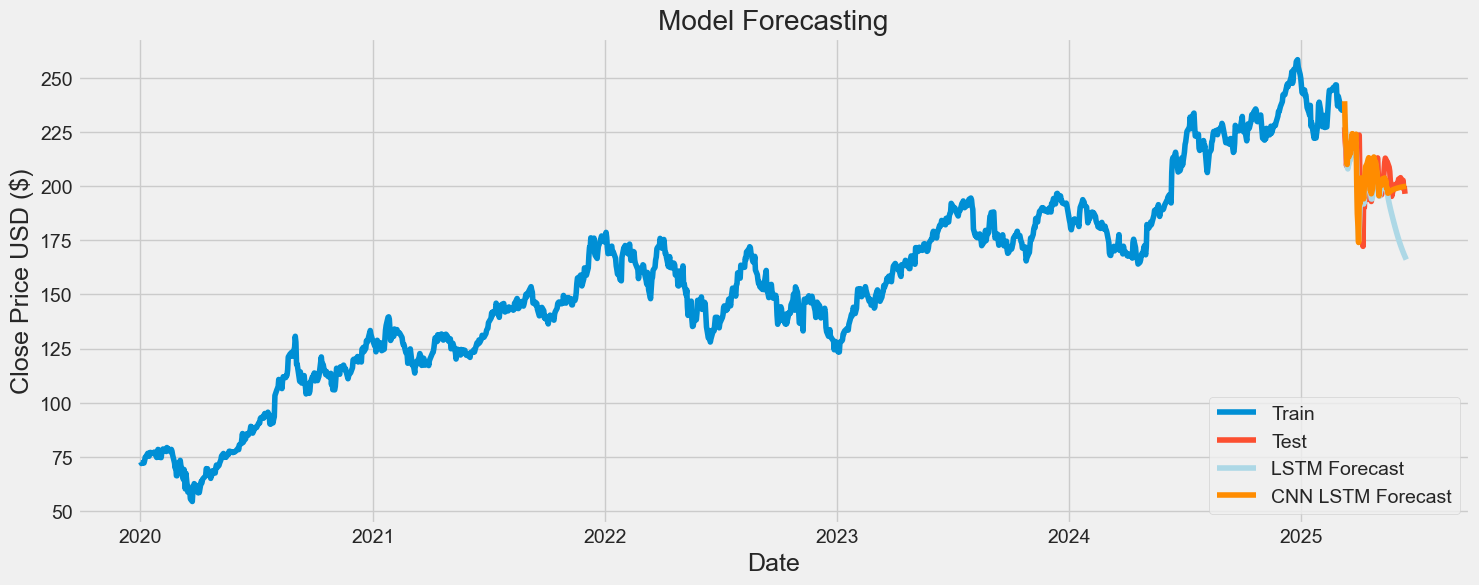

In [27]:
plt.figure(figsize=(16, 6))
plt.title('Model Forecasting')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)

plt.plot(train, label='Train')
plt.plot(test['AAPL'], label='Test')

plt.plot(forecast_df['LSTM_Forecast'], label='LSTM Forecast', color='lightblue')
plt.plot(forecast_df['CNN_LSTM_Forecast'], label='CNN LSTM Forecast', color='darkorange')

plt.legend(loc='lower right')
plt.show()


In [28]:
forecast_df

LSTM_Forecast  CNN_LSTM_Forecast
2025-03-10     233.185303         239.217270
2025-03-11     229.222351         226.715591
2025-03-12     221.757767         219.866211
2025-03-13     215.290359         216.978546
2025-03-14     209.262878         209.993942
...                   ...                ...
2025-06-11     168.850388         199.764404
2025-06-12     168.136353         199.812042
2025-06-13     167.440186         199.857727
2025-06-14     166.760559         199.901855
2025-06-15     166.096283         199.944778

[98 rows x 2 columns]

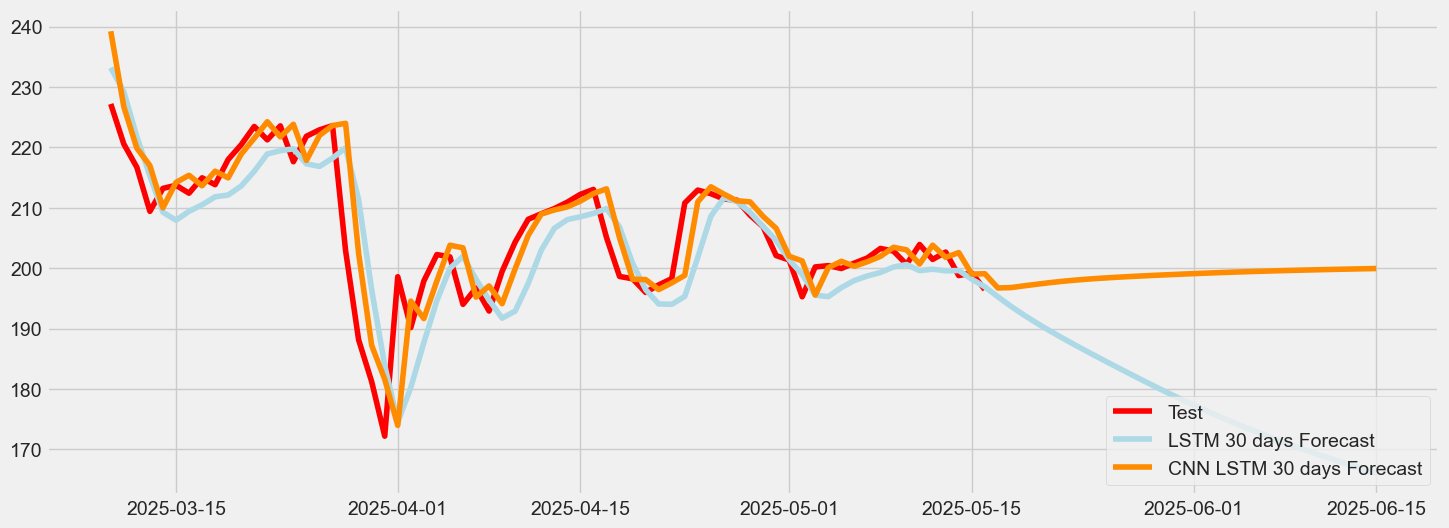

In [29]:
plt.figure(figsize=(16, 6))
test_padded = np.pad(test['AAPL'], (0, 30), mode='constant', constant_values=np.nan)
plt.plot(forecast_df.index,test_padded, label='Test', color='red')
plt.plot(forecast_df.index,forecast_df['LSTM_Forecast'], label='LSTM 30 days Forecast', color='lightblue')
plt.plot(forecast_df.index,forecast_df['CNN_LSTM_Forecast'], label='CNN LSTM 30 days Forecast', color='darkorange')

plt.legend(loc='lower right')
plt.show()


## 3.3 Facebook Prophet

10:32:33 - cmdstanpy - INFO - Chain [1] start processing
10:32:33 - cmdstanpy - INFO - Chain [1] done processing


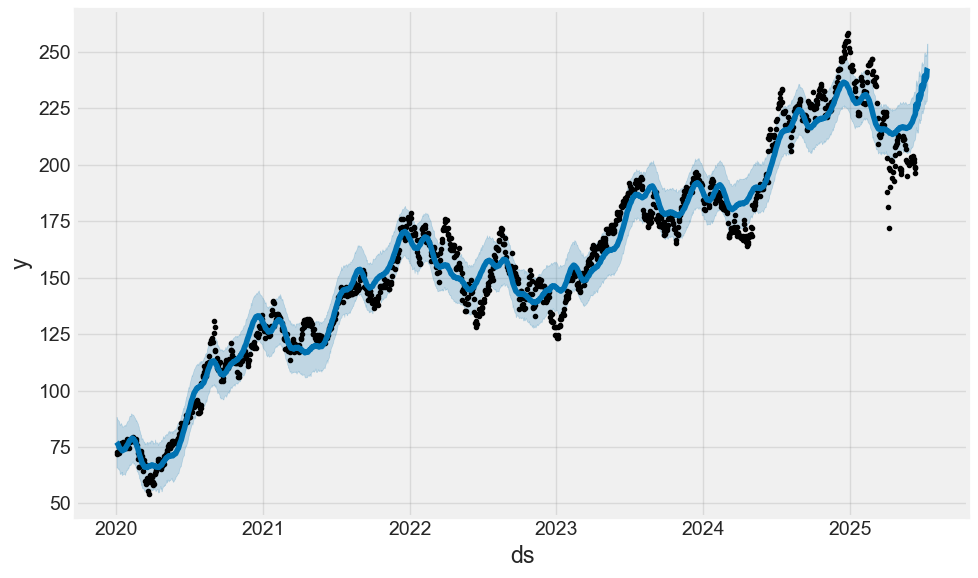

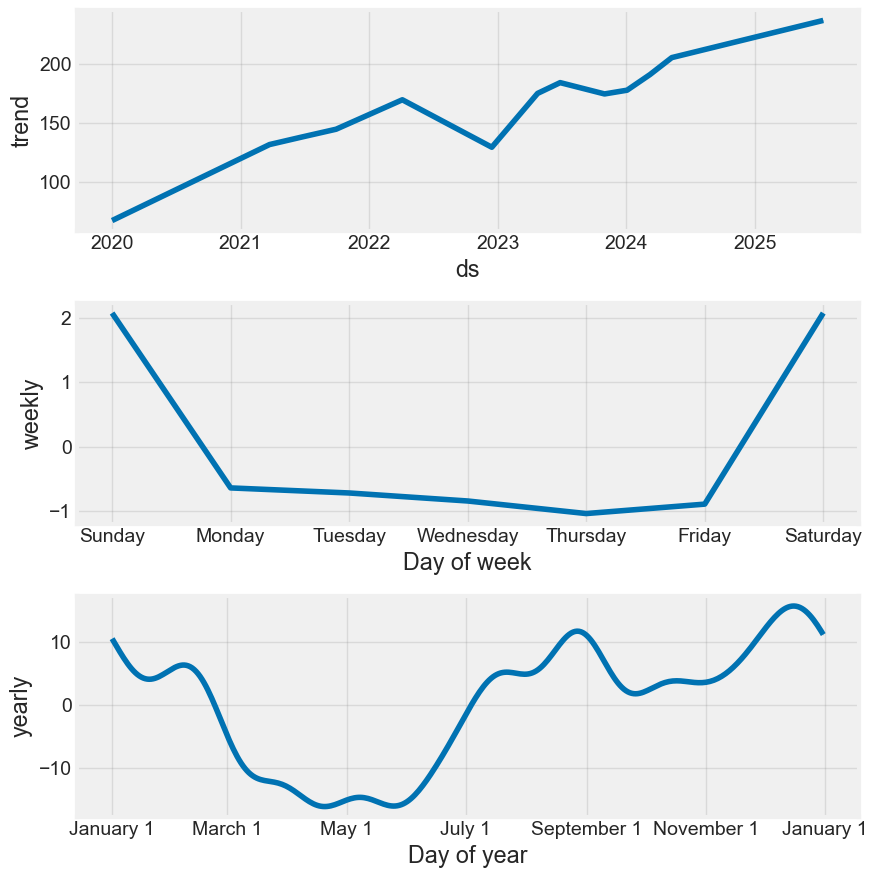

In [30]:
df_prophet = df['Close'].copy()
df_prophet.reset_index(inplace=True)
df_prophet.columns = ['ds', 'y']
model = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False)
model.fit(df_prophet)
future = model.make_future_dataframe(periods=30)
forecast = model.predict(future)
fig1 = model.plot(forecast)

fig2 = model.plot_components(forecast)

In [31]:
prophet_rmse = np.sqrt(np.mean(((forecast.loc[:, 'yhat'] - df_prophet['y']) ** 2)))
print(f"Prophet Root Mean Squared Error(RMSE): {prophet_rmse}")


Prophet Root Mean Squared Error(RMSE): 8.331186046538376


# Results Comparison

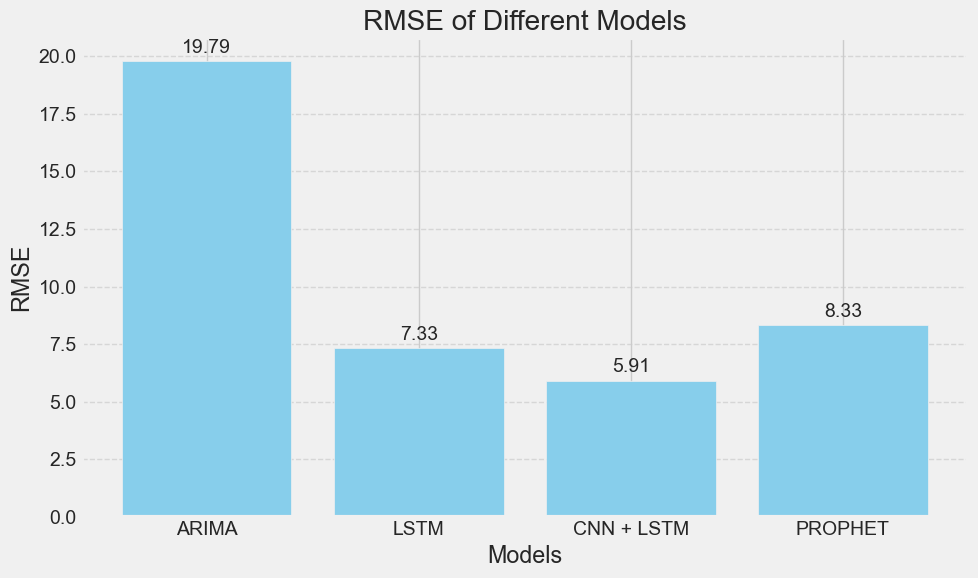

In [32]:
rmse_values = {
    "ARIMA": arima_rmse,
    "LSTM": lstm_rmse,
    "CNN + LSTM": cnn_lstm_rmse,
    "PROPHET": prophet_rmse,
}

models = list(rmse_values.keys())
rmse = list(rmse_values.values())

plt.figure(figsize=(10, 6))
bars = plt.bar(models, rmse, color='skyblue')
plt.xlabel("Models")
plt.ylabel("RMSE")
plt.title("RMSE of Different Models")
plt.ylim(0, max(rmse) + 1)

# Add RMSE values on top of bars
for bar in bars:
    height = bar.get_height()
    plt.annotate(f'{height:.2f}', 
                 xy=(bar.get_x() + bar.get_width() / 2, height),
                 xytext=(0, 3), 
                 textcoords="offset points",
                 ha='center', va='bottom')

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()